# Import packages

In [1]:
# Reading/Writing Data
import os
import glob
import numpy as np
import math 
import matplotlib.pyplot as plt

# Pytorch
import torch 
from torch.utils.data import DataLoader, random_split

# Self-Defined Package
from SMAPDataset import SMAPDataset
from SMCNN import SMCNN
from SDLoss import self_defined_sm_loss
from Preprocessing import random_spatial_sequence, collate_fn, collate_insitu_validation

C:\Users\jianer\anaconda3\envs\datamining\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Some Utility Functions

In [2]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Configurations
`config` contains hyper-parameters for training and the path to save your model.

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 11611801,      # Your seed number, you can pick your lucky number. :)
    'is_train': True,
    'test_ratio': 0.2,
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 5000,     # Number of epochs.            
    'train_batch_size': 30, 
    'valid_batch_size': 57,
    'test_batch_size': 72,
    'sim_threshold': 0.9,
    'learning_rate': 5e-4,
    'step_size': 10,
    'gamma': 0.5,
    'momentum': 0.9,
    'early_stop': 100,    # If model has not improved for this many consecutive epochs, stop training.     
    'root': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\SE',
    'model_save_dir': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\SE\\OUTPUT\\MODELS\\CNN_FROM_INSITU'
}

# Dataloader
Read data from files and set up training, validation, and testing sets.

In [4]:
# # Set seed for reproducibility
same_seed(config['seed'])

In [5]:
# 创建数据集
dataset = SMAPDataset(config['root'], insitu_validation=True)

***************************Load data path******************************
_______________________________2015104_______________________________
_____________________________smap cell: 15_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\GRID_70\2015104\15.npy
_____________________________smap cell: 17_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\GRID_70\2015104\17.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\SMAP\2015104\17.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\TEXTURE\17.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\NDVI\GRID\2015104\17.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\SMAP\2015104\17.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\GR

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\GRID_70\2015165\8.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\SMAP\2015165\8.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\TEXTURE\8.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\NDVI\GRID\2015165\8.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\SMAP\2015165\8.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\GRID_70\2015165\8.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\SM\2015165\30.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\INSITU\2015165\30.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\SM\2015165\22.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\INSITU\2015229\27.npy
_____________________________smap cell: 26_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\GRID_70\2015229\26.npy
_____________________________smap cell: 27_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\GRID_70\2015229\27.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\SMAP\2015229\27.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\TEXTURE\27.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\NDVI\GRID\2015229\27.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\SMAP\2015229\27.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\GRID_70\2015229\27.npy
D:\1GRADUATED

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\GRID_70\2015288\32.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\SMAP\2015288\32.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\TEXTURE\32.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\NDVI\GRID\2015288\32.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\SMAP\2015288\32.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\GRID_70\2015288\32.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\SM\2015288\54.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\INSITU\2015288\54.npy
_____________________________smap cell: 33_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\GRID_70\

In [6]:
# 计算训练集和测试集的长度
train_len = int(len(dataset) * (1-config['test_ratio']))
test_len = len(dataset) - train_len

# 使用 random_split 函数进行划分
train_dataset, test_dataset = random_split(dataset, [train_len, test_len])

# 计算训练集和验证集的长度
valid_len = int(train_len * (config['valid_ratio']))
train_len = train_len - valid_len

# 使用 random_split 函数进行划分
train_dataset, valid_dataset = random_split(train_dataset, [train_len, valid_len])

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=config['train_batch_size'], shuffle=True, collate_fn=collate_insitu_validation)
valid_loader = DataLoader(valid_dataset, batch_size=config['valid_batch_size'], shuffle=True, collate_fn=collate_insitu_validation)
test_loader = DataLoader(test_dataset, batch_size=config['test_batch_size'], shuffle=False, collate_fn=collate_insitu_validation)

print('training size', len(train_dataset))
print('validing size', len(valid_dataset))
print('testing size', len(test_dataset))

training size 228
validing size 57
testing size 72


# Training Loop

In [7]:
def trainer(train_loader, valid_loader, model, config, device):
    relu = torch.nn.ReLU(inplace=True)
    criterion = self_defined_sm_loss 
    optimizer = torch.optim.SGD(model.parameters(), weight_decay=0.01, lr=config['learning_rate'], momentum=config['momentum']) 
    
    # learning rate decay
    RLRP = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=config['gamma'], patience=config['step_size'], threshold=0.03)

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        if epoch==30:
            config['sim_threshold'] = 0.95
        model.train() # Set your model to train mode.
        
        loss_record = []
        physical_loss_record = []
        sd_nonzero_loss_record = []
        sm_nonzero_loss_record = []
        for data_pkg in train_loader:
            x = data_pkg['processed_data']
            optimizer.zero_grad()               
            pred = model(x)
#             print(pred)
#             x, pred = x.to(device), pred.to(device) 

            physical_loss, sd_nonzero_loss, sm_nonzero_loss = criterion(pred, data_pkg['label_data'], 'Training', config['sim_threshold'])
            loss = physical_loss + sd_nonzero_loss + sm_nonzero_loss
            loss.backward()                     
            optimizer.step()                   
            step += 1
            
            physical_loss_record.append(physical_loss.item())
            sd_nonzero_loss_record.append(sd_nonzero_loss.item())
            sm_nonzero_loss_record.append(sm_nonzero_loss.item())
            loss_record.append(loss.item())
         
        mean_train_physical_loss = sum(physical_loss_record)/len(physical_loss_record)
        mean_train_sd_nonzero_loss = sum(sd_nonzero_loss_record)/len(sd_nonzero_loss_record)
        mean_train_sm_nonzero_loss = sum(sm_nonzero_loss_record)/len(sm_nonzero_loss_record)
        mean_train_loss = sum(loss_record)/len(loss_record)

        model.eval() 
        loss_record = []
        physical_loss_record = []
        sd_nonzero_loss_record = []
        sm_nonzero_loss_record = []
        for data_pkg in valid_loader:
            x = data_pkg['processed_data']
            with torch.no_grad():
                pred = model(x)
#             x, pred = x.to(device), pred.to(device)  
                physical_loss, sd_nonzero_loss, sm_nonzero_loss = criterion(pred, data_pkg['label_data'], 'Validing', config['sim_threshold'])
                loss = physical_loss + sd_nonzero_loss + sm_nonzero_loss
            
                physical_loss_record.append(physical_loss.item())
                sd_nonzero_loss_record.append(sd_nonzero_loss.item())
                sm_nonzero_loss_record.append(sm_nonzero_loss.item())
                loss_record.append(loss.item())

        mean_valid_physical_loss = sum(physical_loss_record)/len(physical_loss_record)
        mean_valid_sd_nonzero_loss = sum(sd_nonzero_loss_record)/len(sd_nonzero_loss_record)
        mean_valid_sm_nonzero_loss = sum(sm_nonzero_loss_record)/len(sm_nonzero_loss_record)
        mean_valid_loss = sum(loss_record)/len(loss_record)
        
        current_lr = (optimizer.param_groups[0])['lr']
        print(f'Epoch [{epoch+1}/{n_epochs}] (LR: {current_lr}):')
        print(f'Train loss: {mean_train_loss:.4f} || Train physical loss: {mean_train_physical_loss:.4f}')
        print(f'Train sd_nonzero_loss: {mean_train_sd_nonzero_loss:.4f} || Train sm_nonzero_loss: {mean_train_sm_nonzero_loss:.4f}')
        print(f'Valid loss: {mean_valid_loss:.4f} || Valid physical loss: {mean_valid_physical_loss:.4f}')
        print(f'Valid sd_nonzero_loss: {mean_valid_sd_nonzero_loss:.4f} || Valid sm_nonzero_loss: {mean_valid_sm_nonzero_loss:.4f}')
           
        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            _name = str(best_loss)
            _name = 'first'
            torch.save(model.state_dict(), os.path.join(config['model_save_dir'], _name + '.ckpt')) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            _name = str(best_loss)
            _name = 'last'
            torch.save(model.state_dict(), os.path.join(config['model_save_dir'], _name + '.ckpt')) # Save your best model
            return
        #         StepLR.step()
        RLRP.step(mean_valid_loss)

# Start training!

(11, 11, 20)
SMCNN(
  (cnn): Sequential(
    (0): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3872, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=2, bias=True)
  )
)


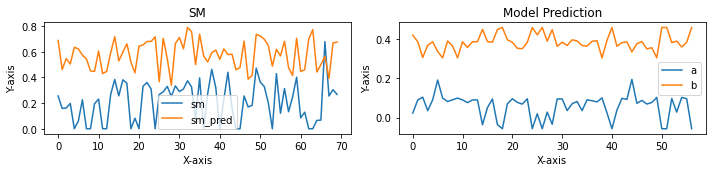

Epoch [1/5000] (LR: 0.0005):
Train loss: 1.4518 || Train physical loss: 0.1609
Train sd_nonzero_loss: 1.0349 || Train sm_nonzero_loss: 0.2560
Valid loss: 1.1968 || Valid physical loss: 0.1616
Valid sd_nonzero_loss: 1.0353 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 1.197...


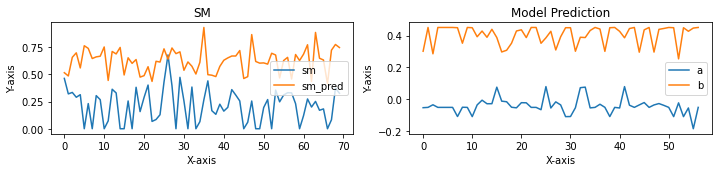

Epoch [2/5000] (LR: 0.0005):
Train loss: 1.6079 || Train physical loss: 0.1384
Train sd_nonzero_loss: 0.9129 || Train sm_nonzero_loss: 0.5566
Valid loss: 1.2473 || Valid physical loss: 0.2101
Valid sd_nonzero_loss: 1.0373 || Valid sm_nonzero_loss: 0.0000


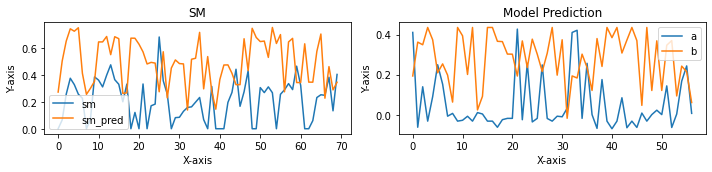

Epoch [3/5000] (LR: 0.0005):
Train loss: 1.2075 || Train physical loss: 0.1653
Train sd_nonzero_loss: 1.0422 || Train sm_nonzero_loss: 0.0000
Valid loss: 1.1555 || Valid physical loss: 0.1318
Valid sd_nonzero_loss: 1.0237 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 1.155...


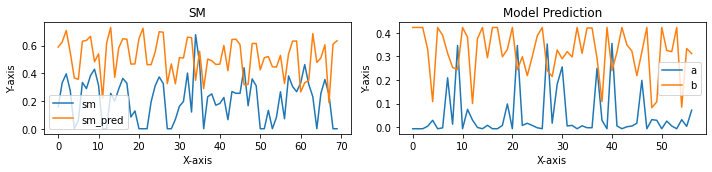

Epoch [4/5000] (LR: 0.0005):
Train loss: 1.5289 || Train physical loss: 0.1281
Train sd_nonzero_loss: 1.0144 || Train sm_nonzero_loss: 0.3864
Valid loss: 1.1362 || Valid physical loss: 0.1322
Valid sd_nonzero_loss: 1.0040 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 1.136...


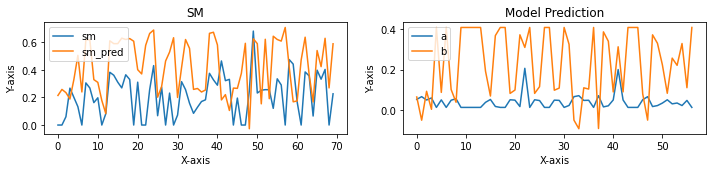

Epoch [5/5000] (LR: 0.0005):
Train loss: 0.7525 || Train physical loss: 0.1005
Train sd_nonzero_loss: 0.3758 || Train sm_nonzero_loss: 0.2762
Valid loss: 1.1163 || Valid physical loss: 0.0975
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 1.0187
Saving model with loss 1.116...


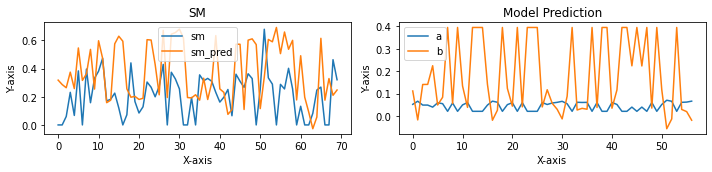

Epoch [6/5000] (LR: 0.0005):
Train loss: 0.0858 || Train physical loss: 0.0858
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 1.1003 || Valid physical loss: 0.0814
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 1.0189
Saving model with loss 1.100...


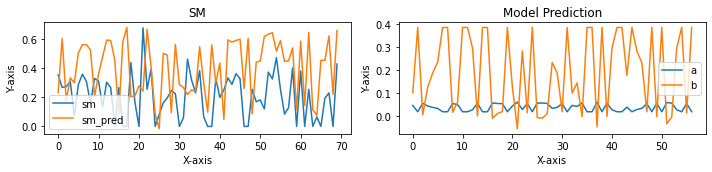

Epoch [7/5000] (LR: 0.0005):
Train loss: 0.2086 || Train physical loss: 0.0759
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1327
Valid loss: 1.0977 || Valid physical loss: 0.0866
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 1.0111
Saving model with loss 1.098...


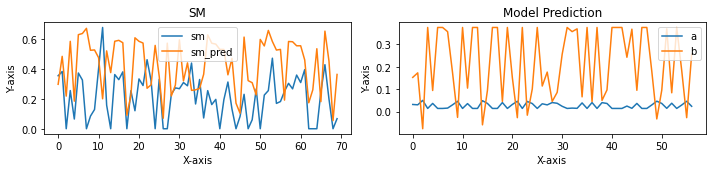

Epoch [8/5000] (LR: 0.0005):
Train loss: 0.2009 || Train physical loss: 0.0748
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1261
Valid loss: 0.0896 || Valid physical loss: 0.0896
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.090...


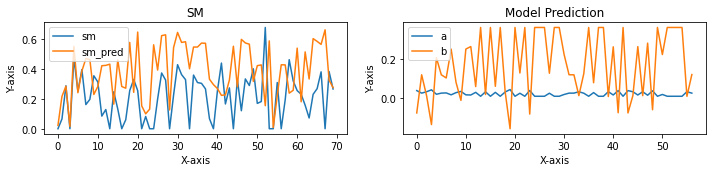

Epoch [9/5000] (LR: 0.0005):
Train loss: 0.0729 || Train physical loss: 0.0729
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0785 || Valid physical loss: 0.0785
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.079...


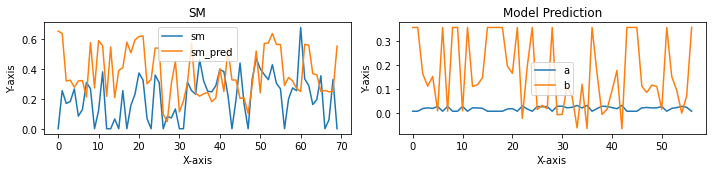

Epoch [10/5000] (LR: 0.0005):
Train loss: 0.1916 || Train physical loss: 0.0644
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1272
Valid loss: 0.0709 || Valid physical loss: 0.0709
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.071...


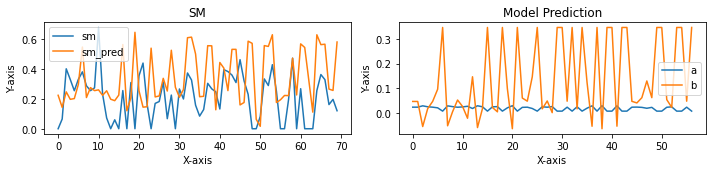

Epoch [11/5000] (LR: 0.0005):
Train loss: 0.0580 || Train physical loss: 0.0580
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0635 || Valid physical loss: 0.0635
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.063...


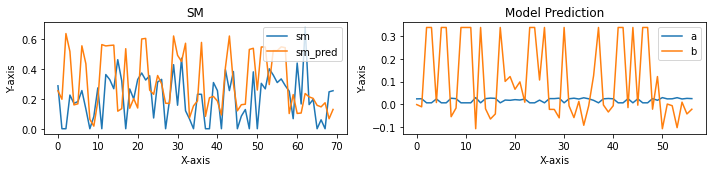

Epoch [12/5000] (LR: 0.0005):
Train loss: 0.0534 || Train physical loss: 0.0534
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0596 || Valid physical loss: 0.0596
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.060...


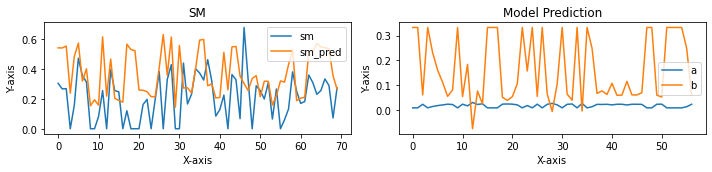

Epoch [13/5000] (LR: 0.0005):
Train loss: 0.1772 || Train physical loss: 0.0490
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1282
Valid loss: 0.0608 || Valid physical loss: 0.0608
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


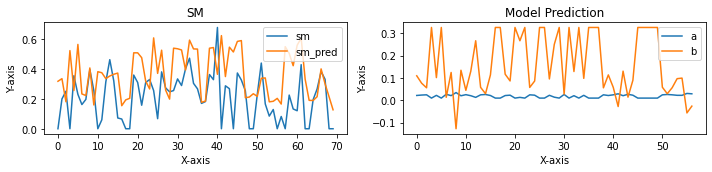

Epoch [14/5000] (LR: 0.0005):
Train loss: 0.1839 || Train physical loss: 0.0510
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1329
Valid loss: 0.0597 || Valid physical loss: 0.0597
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


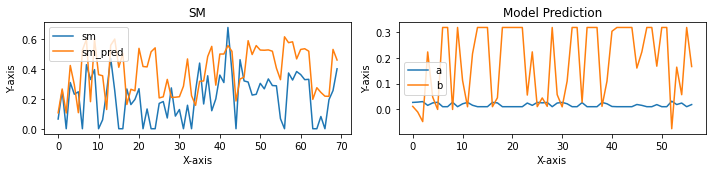

Epoch [15/5000] (LR: 0.0005):
Train loss: 0.0551 || Train physical loss: 0.0551
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0669 || Valid physical loss: 0.0669
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


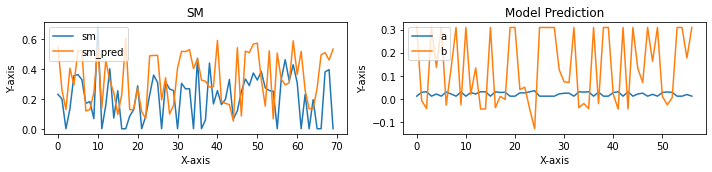

Epoch [16/5000] (LR: 0.0005):
Train loss: 0.1770 || Train physical loss: 0.0498
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1272
Valid loss: 0.0594 || Valid physical loss: 0.0594
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.059...


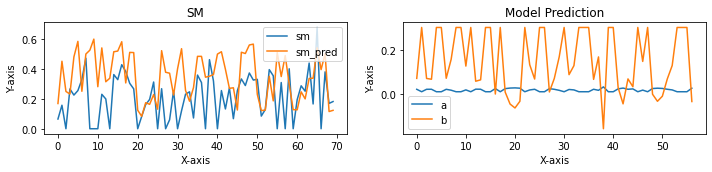

Epoch [17/5000] (LR: 0.0005):
Train loss: 0.1758 || Train physical loss: 0.0508
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1251
Valid loss: 0.0609 || Valid physical loss: 0.0609
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


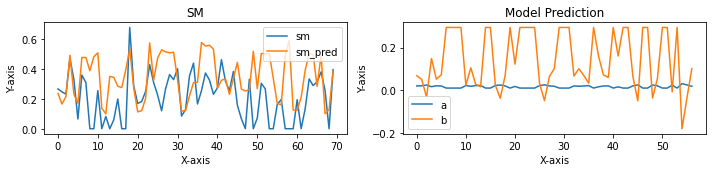

Epoch [18/5000] (LR: 0.0005):
Train loss: 0.0489 || Train physical loss: 0.0489
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0568 || Valid physical loss: 0.0568
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.057...


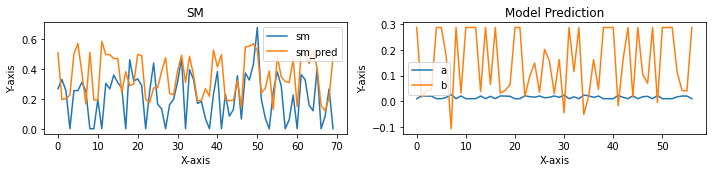

Epoch [19/5000] (LR: 0.0005):
Train loss: 0.1712 || Train physical loss: 0.0438
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1274
Valid loss: 0.0541 || Valid physical loss: 0.0541
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.054...


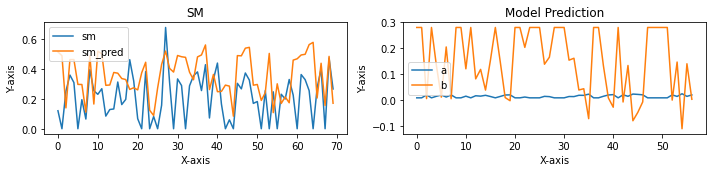

Epoch [20/5000] (LR: 0.0005):
Train loss: 0.0456 || Train physical loss: 0.0456
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0540 || Valid physical loss: 0.0540
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.054...


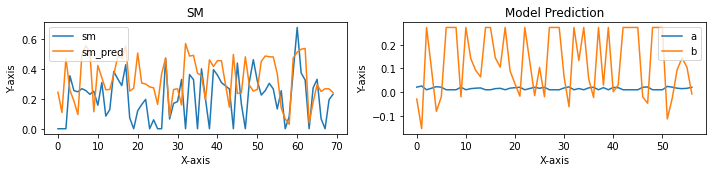

Epoch [21/5000] (LR: 0.0005):
Train loss: 0.1673 || Train physical loss: 0.0408
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1265
Valid loss: 0.0506 || Valid physical loss: 0.0506
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.051...


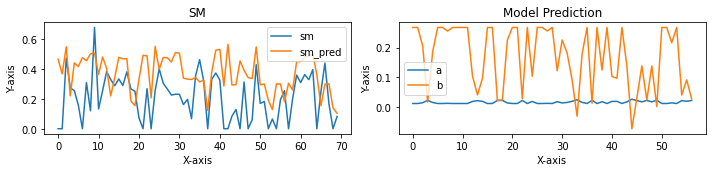

Epoch [22/5000] (LR: 0.0005):
Train loss: 0.1746 || Train physical loss: 0.0461
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1286
Valid loss: 0.0549 || Valid physical loss: 0.0549
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


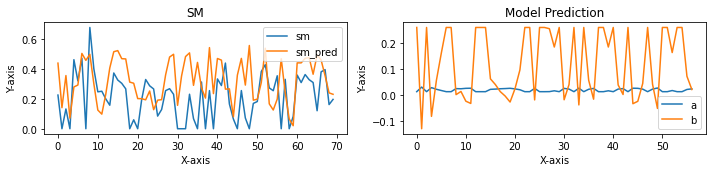

Epoch [23/5000] (LR: 0.0005):
Train loss: 0.1729 || Train physical loss: 0.0476
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1253
Valid loss: 0.0490 || Valid physical loss: 0.0490
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.049...


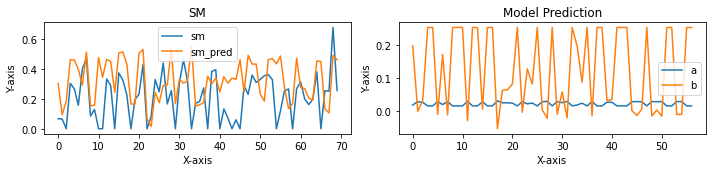

Epoch [24/5000] (LR: 0.0005):
Train loss: 0.0450 || Train physical loss: 0.0450
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0483 || Valid physical loss: 0.0483
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.048...


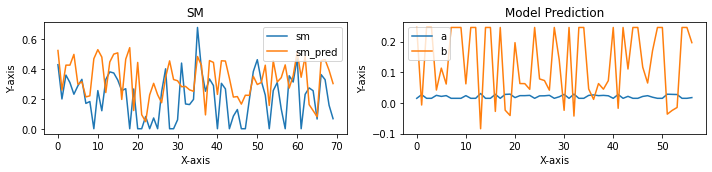

Epoch [25/5000] (LR: 0.0005):
Train loss: 0.1698 || Train physical loss: 0.0417
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1281
Valid loss: 0.0465 || Valid physical loss: 0.0465
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.047...


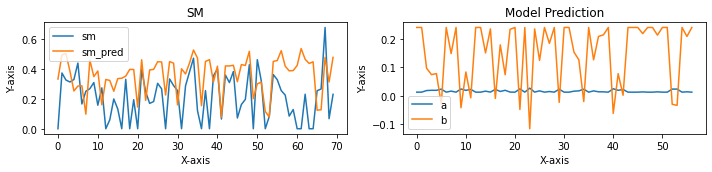

Epoch [26/5000] (LR: 0.0005):
Train loss: 0.0419 || Train physical loss: 0.0419
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0513 || Valid physical loss: 0.0513
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


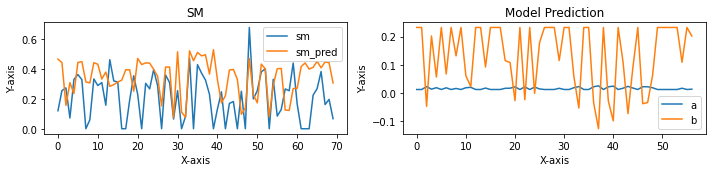

Epoch [27/5000] (LR: 0.0005):
Train loss: 0.1647 || Train physical loss: 0.0372
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1275
Valid loss: 0.0485 || Valid physical loss: 0.0485
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


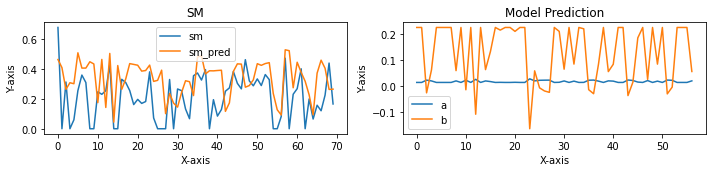

Epoch [28/5000] (LR: 0.0005):
Train loss: 0.0357 || Train physical loss: 0.0357
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0464 || Valid physical loss: 0.0464
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.046...


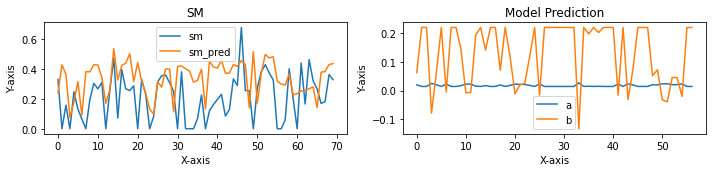

Epoch [29/5000] (LR: 0.0005):
Train loss: 0.1624 || Train physical loss: 0.0338
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1285
Valid loss: 0.0448 || Valid physical loss: 0.0448
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.045...


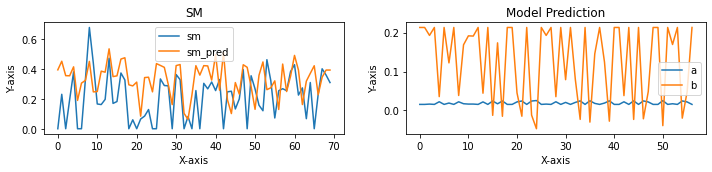

Epoch [30/5000] (LR: 0.0005):
Train loss: 0.0356 || Train physical loss: 0.0356
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0436 || Valid physical loss: 0.0436
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.044...


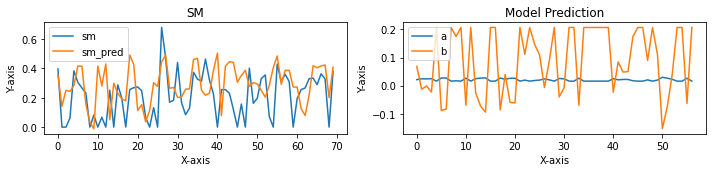

Epoch [31/5000] (LR: 0.0005):
Train loss: 0.0315 || Train physical loss: 0.0315
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 1.0478 || Valid physical loss: 0.0401
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 1.0077


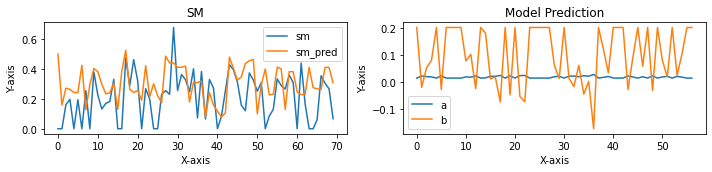

Epoch [32/5000] (LR: 0.0005):
Train loss: 0.1574 || Train physical loss: 0.0311
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1263
Valid loss: 0.0376 || Valid physical loss: 0.0376
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.038...


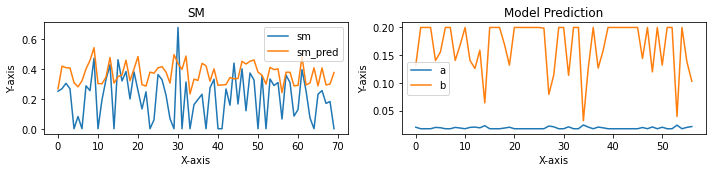

Epoch [33/5000] (LR: 0.0005):
Train loss: 0.1624 || Train physical loss: 0.0371
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1253
Valid loss: 0.0457 || Valid physical loss: 0.0457
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


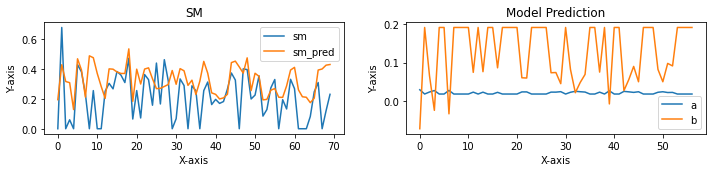

Epoch [34/5000] (LR: 0.0005):
Train loss: 0.0412 || Train physical loss: 0.0412
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0365 || Valid physical loss: 0.0365
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.036...


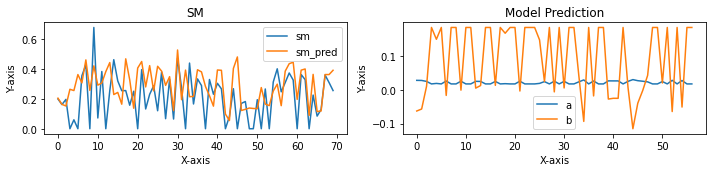

Epoch [35/5000] (LR: 0.0005):
Train loss: 0.1569 || Train physical loss: 0.0311
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1258
Valid loss: 0.0332 || Valid physical loss: 0.0332
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.033...


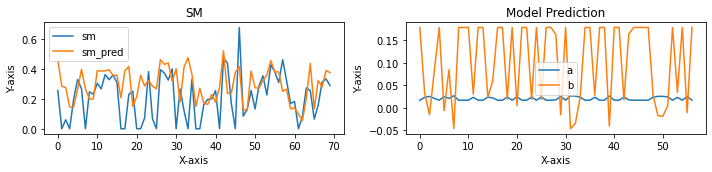

Epoch [36/5000] (LR: 0.0005):
Train loss: 0.0308 || Train physical loss: 0.0308
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0334 || Valid physical loss: 0.0334
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


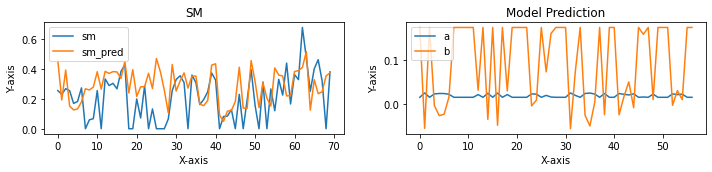

Epoch [37/5000] (LR: 0.0005):
Train loss: 0.0318 || Train physical loss: 0.0318
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0321 || Valid physical loss: 0.0321
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.032...


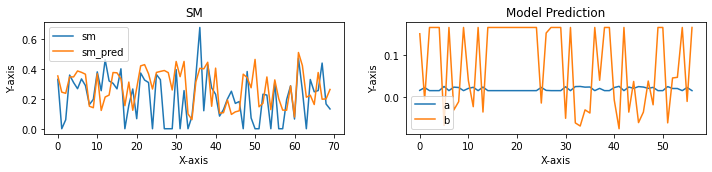

Epoch [38/5000] (LR: 0.0005):
Train loss: 0.0293 || Train physical loss: 0.0293
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0306 || Valid physical loss: 0.0306
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.031...


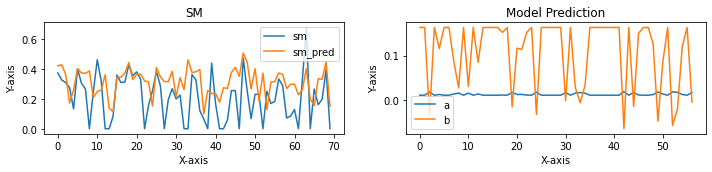

Epoch [39/5000] (LR: 0.0005):
Train loss: 0.1546 || Train physical loss: 0.0288
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1259
Valid loss: 0.0333 || Valid physical loss: 0.0333
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


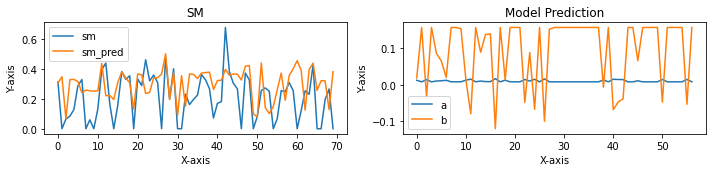

Epoch [40/5000] (LR: 0.0005):
Train loss: 0.0295 || Train physical loss: 0.0295
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0324 || Valid physical loss: 0.0324
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


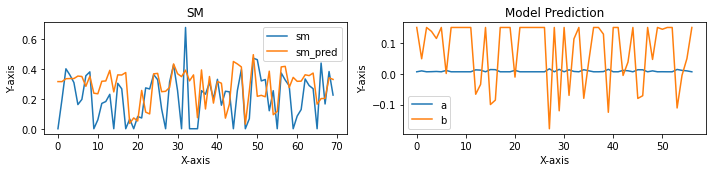

Epoch [41/5000] (LR: 0.0005):
Train loss: 0.0271 || Train physical loss: 0.0271
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0316 || Valid physical loss: 0.0316
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


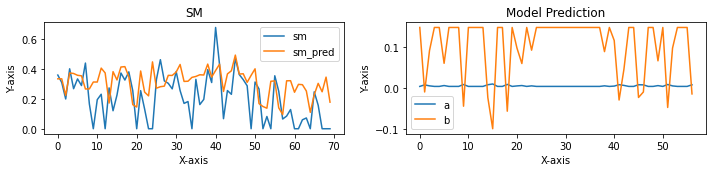

Epoch [42/5000] (LR: 0.0005):
Train loss: 0.1552 || Train physical loss: 0.0286
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1266
Valid loss: 0.0314 || Valid physical loss: 0.0314
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


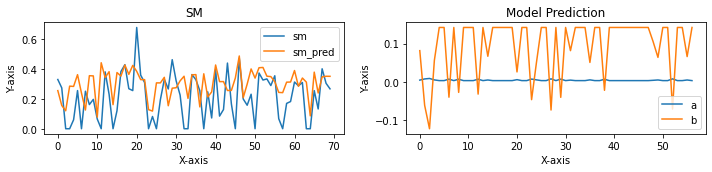

Epoch [43/5000] (LR: 0.0005):
Train loss: 0.0286 || Train physical loss: 0.0286
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0301 || Valid physical loss: 0.0301
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.030...


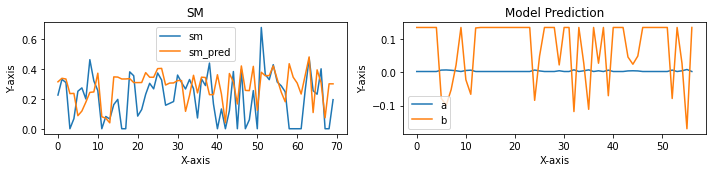

Epoch [44/5000] (LR: 0.0005):
Train loss: 0.0264 || Train physical loss: 0.0264
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0291 || Valid physical loss: 0.0291
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.029...


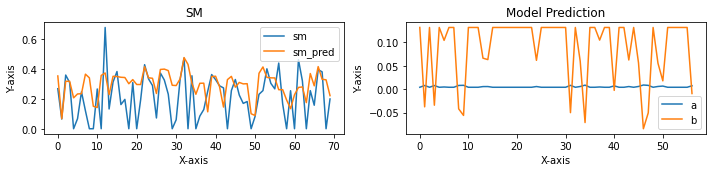

Epoch [45/5000] (LR: 0.0005):
Train loss: 0.1562 || Train physical loss: 0.0265
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1297
Valid loss: 0.0290 || Valid physical loss: 0.0290
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.029...


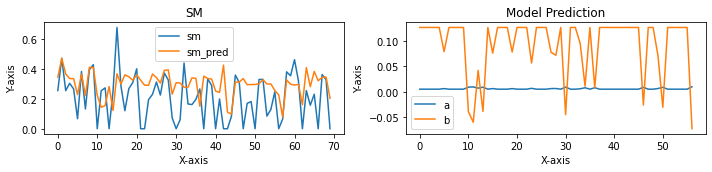

Epoch [46/5000] (LR: 0.0005):
Train loss: 0.0288 || Train physical loss: 0.0288
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0295 || Valid physical loss: 0.0295
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


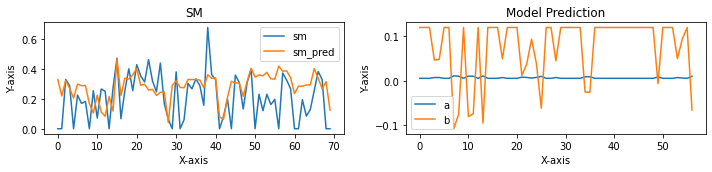

Epoch [47/5000] (LR: 0.0005):
Train loss: 0.0273 || Train physical loss: 0.0273
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0280 || Valid physical loss: 0.0280
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.028...


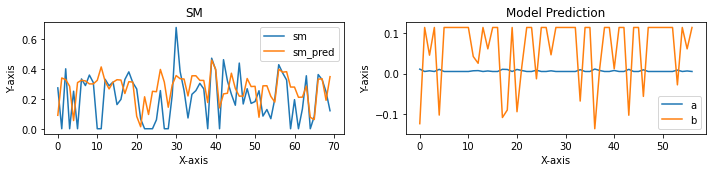

Epoch [48/5000] (LR: 0.0005):
Train loss: 0.0254 || Train physical loss: 0.0254
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0270 || Valid physical loss: 0.0270
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.027...


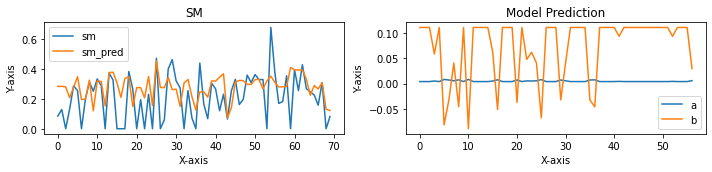

Epoch [49/5000] (LR: 0.0005):
Train loss: 0.1499 || Train physical loss: 0.0240
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1259
Valid loss: 0.0253 || Valid physical loss: 0.0253
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.025...


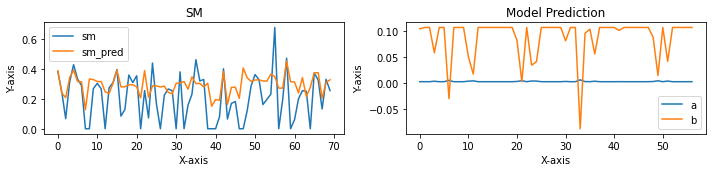

Epoch [50/5000] (LR: 0.0005):
Train loss: 0.0248 || Train physical loss: 0.0248
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0258 || Valid physical loss: 0.0258
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


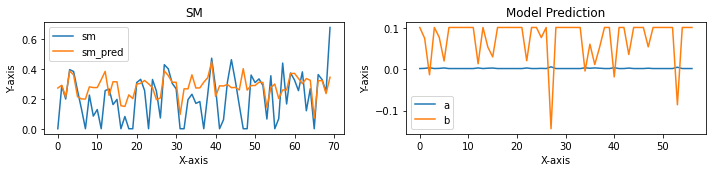

Epoch [51/5000] (LR: 0.0005):
Train loss: 0.0243 || Train physical loss: 0.0243
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0241 || Valid physical loss: 0.0241
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.024...


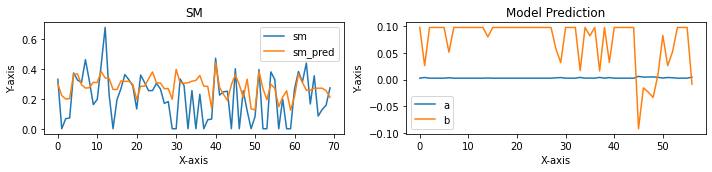

Epoch [52/5000] (LR: 0.0005):
Train loss: 0.1501 || Train physical loss: 0.0227
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1274
Valid loss: 0.0238 || Valid physical loss: 0.0238
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.024...


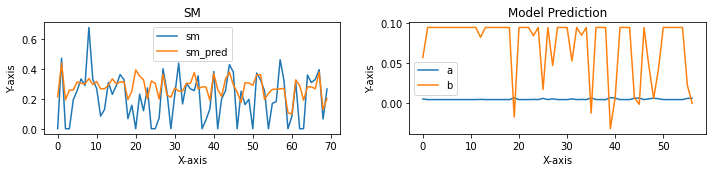

Epoch [53/5000] (LR: 0.0005):
Train loss: 0.0249 || Train physical loss: 0.0249
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0243 || Valid physical loss: 0.0243
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


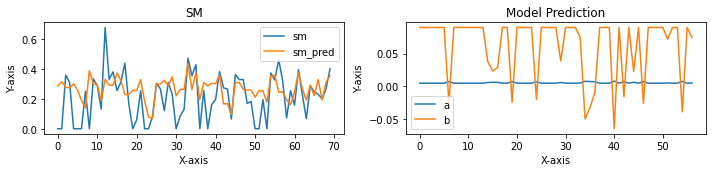

Epoch [54/5000] (LR: 0.0005):
Train loss: 0.0238 || Train physical loss: 0.0238
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0234 || Valid physical loss: 0.0234
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.023...


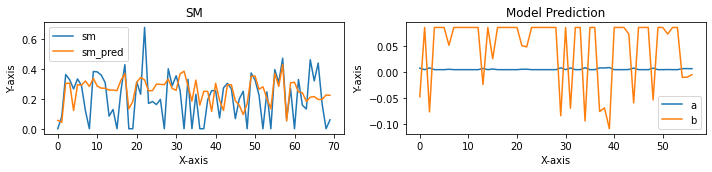

Epoch [55/5000] (LR: 0.0005):
Train loss: 0.0221 || Train physical loss: 0.0221
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0226 || Valid physical loss: 0.0226
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.023...


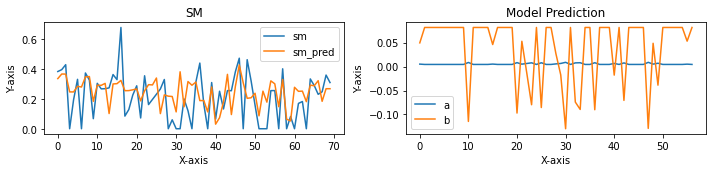

Epoch [56/5000] (LR: 0.0005):
Train loss: 0.0213 || Train physical loss: 0.0213
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0223 || Valid physical loss: 0.0223
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.022...


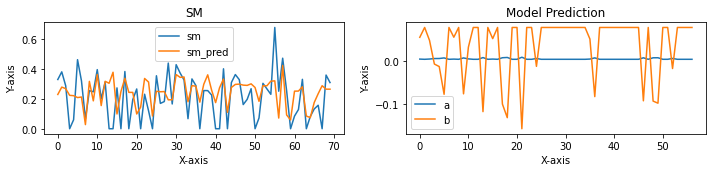

Epoch [57/5000] (LR: 0.0005):
Train loss: 0.0206 || Train physical loss: 0.0206
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0218 || Valid physical loss: 0.0218
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.022...


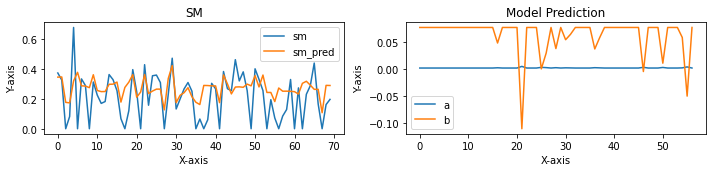

Epoch [58/5000] (LR: 0.0005):
Train loss: 0.1487 || Train physical loss: 0.0211
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1277
Valid loss: 0.0221 || Valid physical loss: 0.0221
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


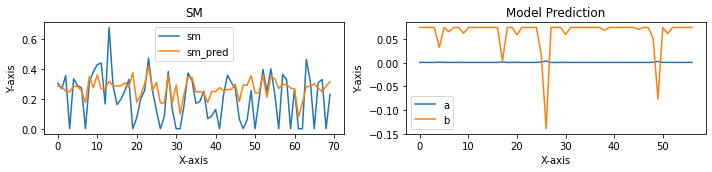

Epoch [59/5000] (LR: 0.0005):
Train loss: 0.0215 || Train physical loss: 0.0215
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0221 || Valid physical loss: 0.0221
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


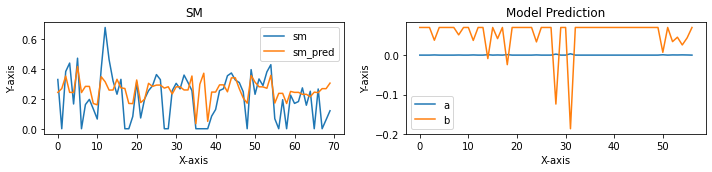

Epoch [60/5000] (LR: 0.0005):
Train loss: 0.0214 || Train physical loss: 0.0214
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0210 || Valid physical loss: 0.0210
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.021...


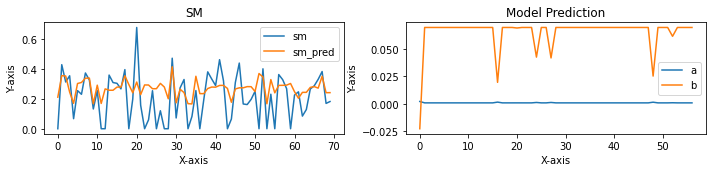

Epoch [61/5000] (LR: 0.0005):
Train loss: 0.1489 || Train physical loss: 0.0221
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1267
Valid loss: 0.0229 || Valid physical loss: 0.0229
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


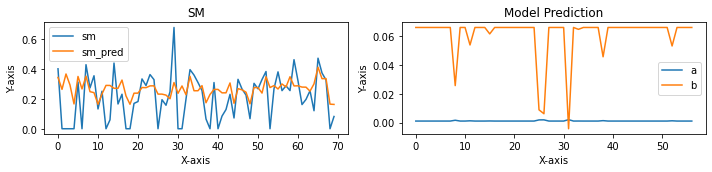

Epoch [62/5000] (LR: 0.0005):
Train loss: 0.0230 || Train physical loss: 0.0230
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0227 || Valid physical loss: 0.0227
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


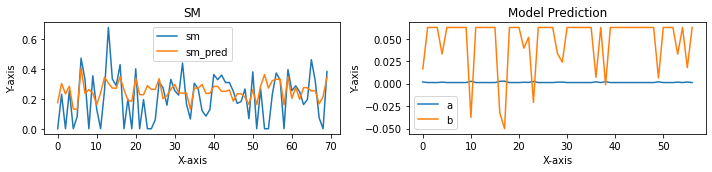

Epoch [63/5000] (LR: 0.0005):
Train loss: 0.0213 || Train physical loss: 0.0213
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0209 || Valid physical loss: 0.0209
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.021...


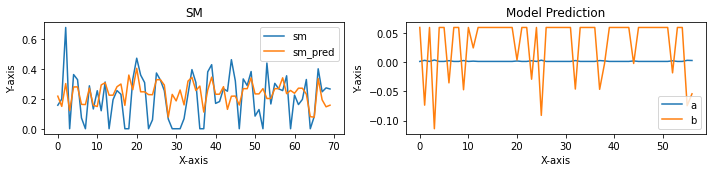

Epoch [64/5000] (LR: 0.0005):
Train loss: 0.0202 || Train physical loss: 0.0202
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0198 || Valid physical loss: 0.0198
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.020...


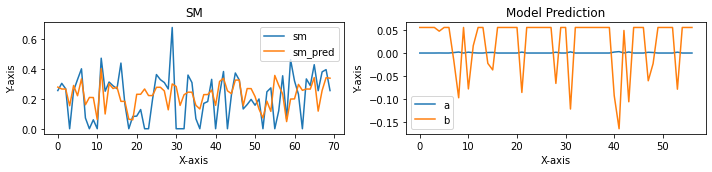

Epoch [65/5000] (LR: 0.0005):
Train loss: 0.0195 || Train physical loss: 0.0195
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0198 || Valid physical loss: 0.0198
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.020...


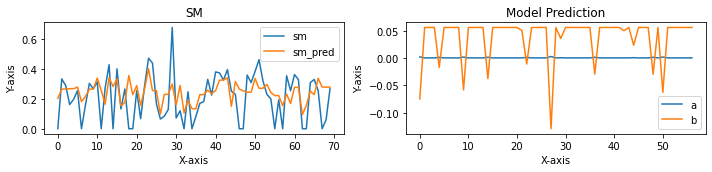

Epoch [66/5000] (LR: 0.0005):
Train loss: 0.1446 || Train physical loss: 0.0192
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1254
Valid loss: 0.0196 || Valid physical loss: 0.0196
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.020...


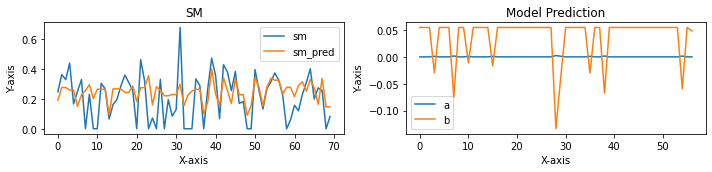

Epoch [67/5000] (LR: 0.0005):
Train loss: 0.0200 || Train physical loss: 0.0200
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0196 || Valid physical loss: 0.0196
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.020...


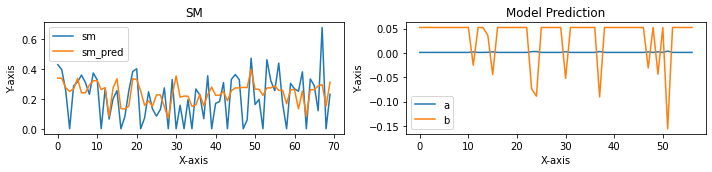

Epoch [68/5000] (LR: 0.0005):
Train loss: 0.1451 || Train physical loss: 0.0201
Train sd_nonzero_loss: 0.1250 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0193 || Valid physical loss: 0.0193
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.019...


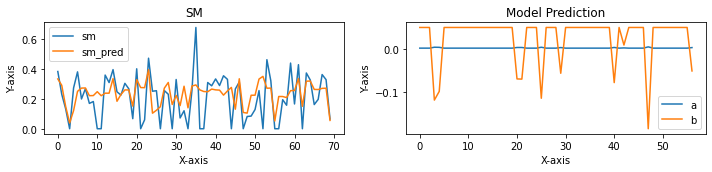

Epoch [69/5000] (LR: 0.0005):
Train loss: 0.0193 || Train physical loss: 0.0193
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0192 || Valid physical loss: 0.0192
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.019...


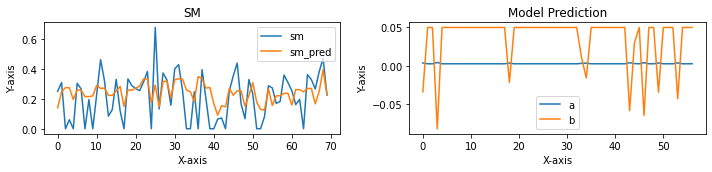

Epoch [70/5000] (LR: 0.0005):
Train loss: 0.1443 || Train physical loss: 0.0190
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1254
Valid loss: 0.0200 || Valid physical loss: 0.0200
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


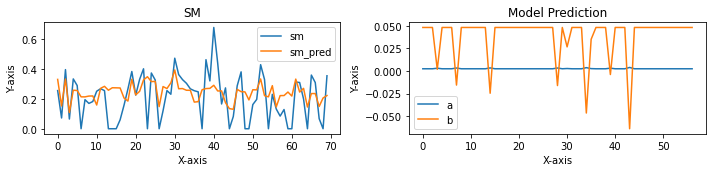

Epoch [71/5000] (LR: 0.0005):
Train loss: 0.0220 || Train physical loss: 0.0220
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0209 || Valid physical loss: 0.0209
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


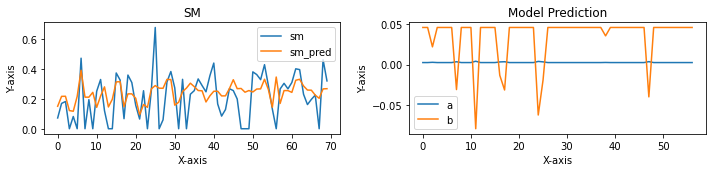

Epoch [72/5000] (LR: 0.0005):
Train loss: 0.0219 || Train physical loss: 0.0219
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0208 || Valid physical loss: 0.0208
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


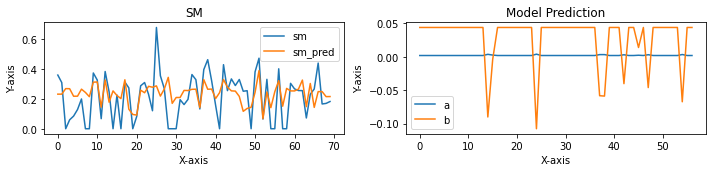

Epoch [73/5000] (LR: 0.0005):
Train loss: 0.0207 || Train physical loss: 0.0207
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0205 || Valid physical loss: 0.0205
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


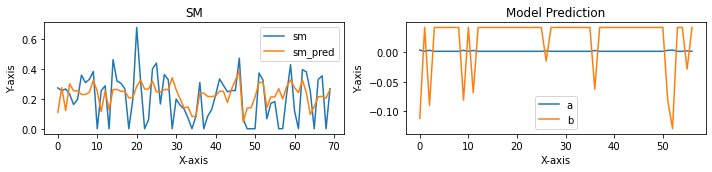

Epoch [74/5000] (LR: 0.0005):
Train loss: 0.0201 || Train physical loss: 0.0201
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0202 || Valid physical loss: 0.0202
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


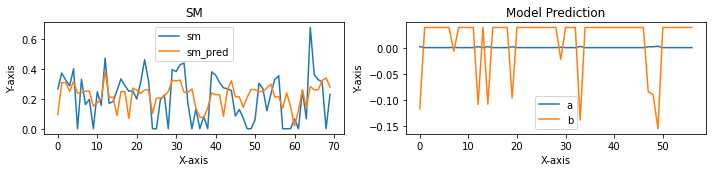

Epoch [75/5000] (LR: 0.0005):
Train loss: 0.0198 || Train physical loss: 0.0198
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0199 || Valid physical loss: 0.0199
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


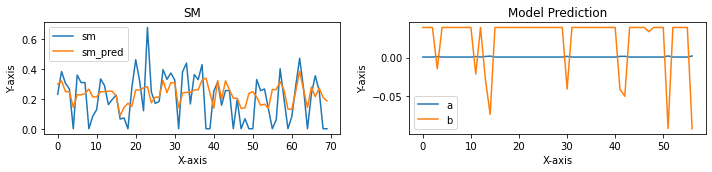

Epoch [76/5000] (LR: 0.0005):
Train loss: 0.3943 || Train physical loss: 0.0190
Train sd_nonzero_loss: 0.2500 || Train sm_nonzero_loss: 0.1254
Valid loss: 0.0192 || Valid physical loss: 0.0192
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.019...


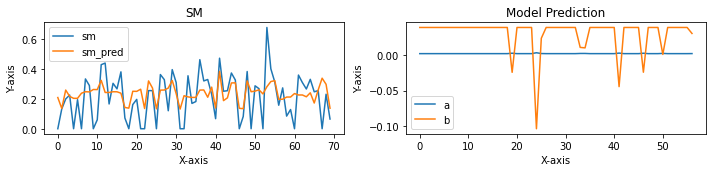

Epoch [77/5000] (LR: 0.0005):
Train loss: 0.0197 || Train physical loss: 0.0197
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0193 || Valid physical loss: 0.0193
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


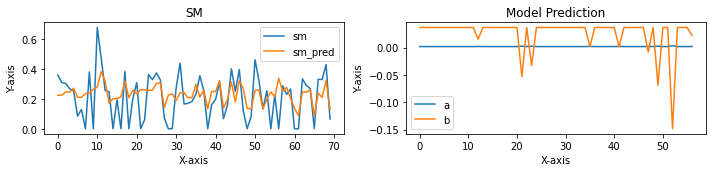

Epoch [78/5000] (LR: 0.0005):
Train loss: 0.0198 || Train physical loss: 0.0198
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0188 || Valid physical loss: 0.0188
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.019...


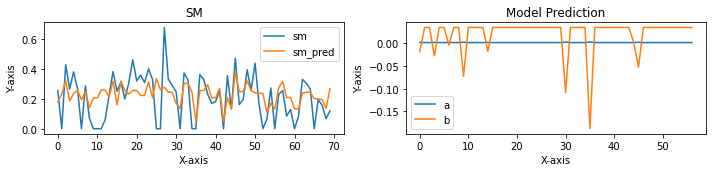

Epoch [79/5000] (LR: 0.0005):
Train loss: 0.0198 || Train physical loss: 0.0198
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0185 || Valid physical loss: 0.0185
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.018...


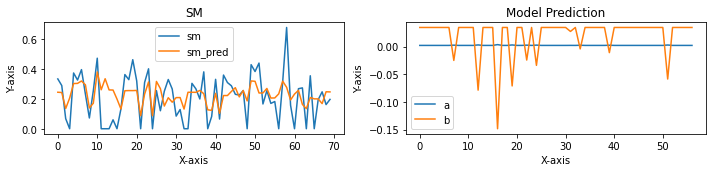

Epoch [80/5000] (LR: 0.0005):
Train loss: 0.1436 || Train physical loss: 0.0180
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1256
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


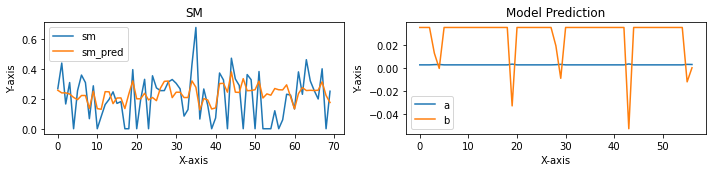

Epoch [81/5000] (LR: 0.0005):
Train loss: 0.0193 || Train physical loss: 0.0193
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0200 || Valid physical loss: 0.0200
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


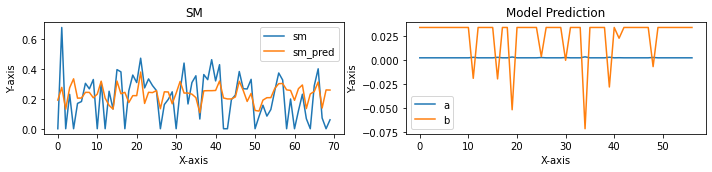

Epoch [82/5000] (LR: 0.0005):
Train loss: 0.0201 || Train physical loss: 0.0201
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0200 || Valid physical loss: 0.0200
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


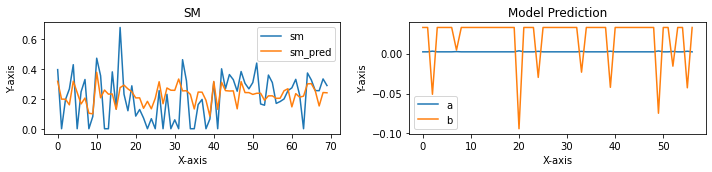

Epoch [83/5000] (LR: 0.0005):
Train loss: 0.0205 || Train physical loss: 0.0205
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0197 || Valid physical loss: 0.0197
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


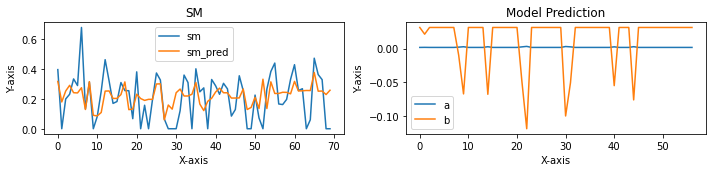

Epoch [84/5000] (LR: 0.0005):
Train loss: 0.0199 || Train physical loss: 0.0199
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0195 || Valid physical loss: 0.0195
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


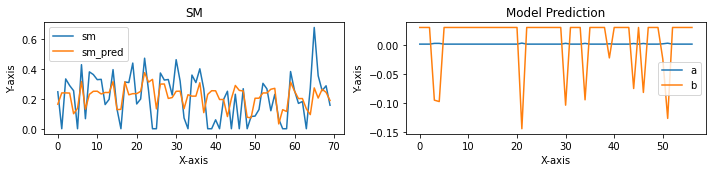

Epoch [85/5000] (LR: 0.0005):
Train loss: 0.0191 || Train physical loss: 0.0191
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0193 || Valid physical loss: 0.0193
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


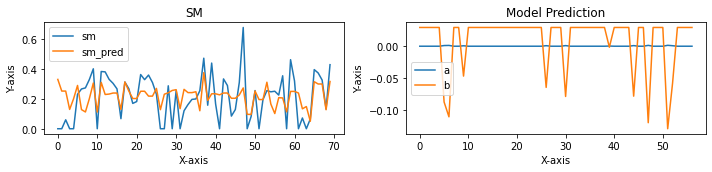

Epoch [86/5000] (LR: 0.0005):
Train loss: 0.1441 || Train physical loss: 0.0187
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1254
Valid loss: 0.0188 || Valid physical loss: 0.0188
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


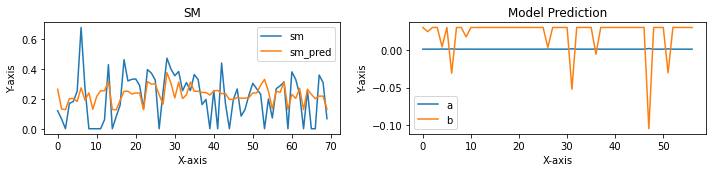

Epoch [87/5000] (LR: 0.0005):
Train loss: 0.2688 || Train physical loss: 0.0187
Train sd_nonzero_loss: 0.2501 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0189 || Valid physical loss: 0.0189
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


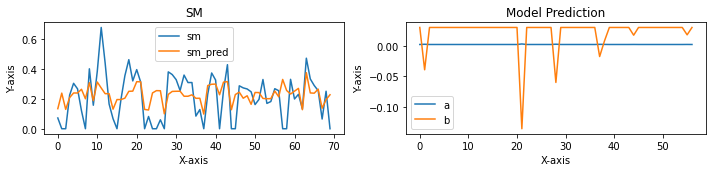

Epoch [88/5000] (LR: 0.0005):
Train loss: 0.0193 || Train physical loss: 0.0193
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0188 || Valid physical loss: 0.0188
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


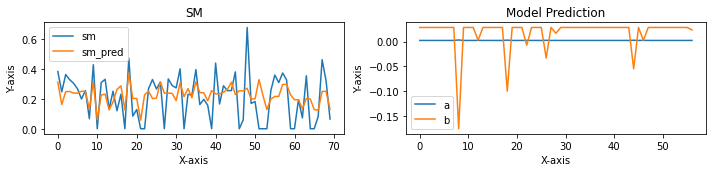

Epoch [89/5000] (LR: 0.0005):
Train loss: 0.0190 || Train physical loss: 0.0190
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0184 || Valid physical loss: 0.0184
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.018...


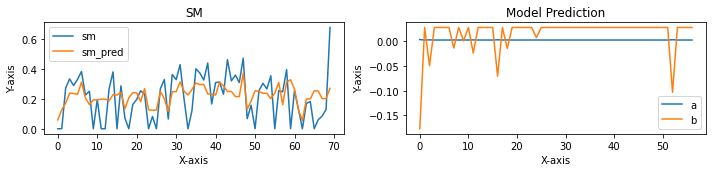

Epoch [90/5000] (LR: 0.0005):
Train loss: 0.1444 || Train physical loss: 0.0187
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1257
Valid loss: 0.0183 || Valid physical loss: 0.0183
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000
Saving model with loss 0.018...


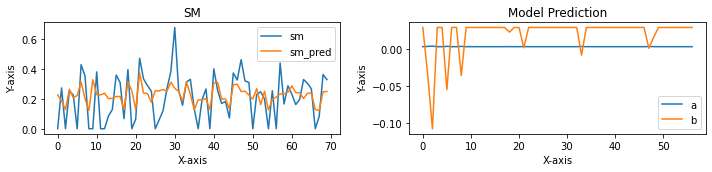

Epoch [91/5000] (LR: 0.00025):
Train loss: 0.0191 || Train physical loss: 0.0191
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0189 || Valid physical loss: 0.0189
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


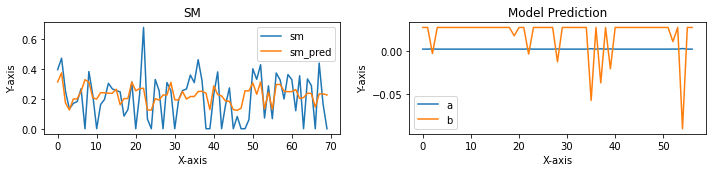

Epoch [92/5000] (LR: 0.00025):
Train loss: 0.0192 || Train physical loss: 0.0192
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0190 || Valid physical loss: 0.0190
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


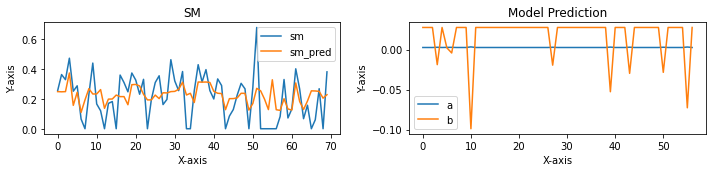

Epoch [93/5000] (LR: 0.00025):
Train loss: 0.0198 || Train physical loss: 0.0198
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0188 || Valid physical loss: 0.0188
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


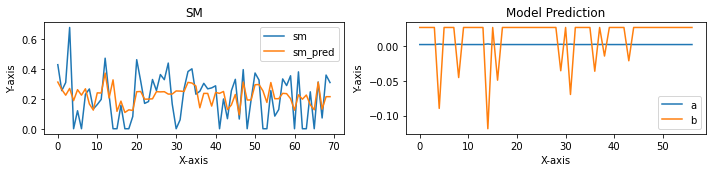

Epoch [94/5000] (LR: 0.00025):
Train loss: 0.0190 || Train physical loss: 0.0190
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


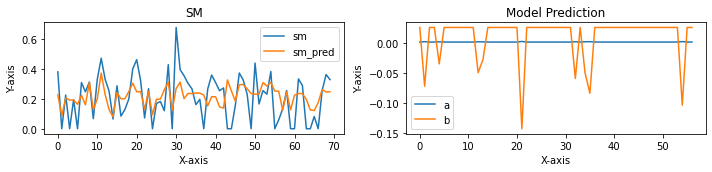

Epoch [95/5000] (LR: 0.00025):
Train loss: 0.0190 || Train physical loss: 0.0190
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0185 || Valid physical loss: 0.0185
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


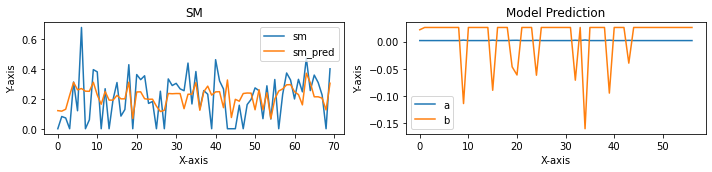

Epoch [96/5000] (LR: 0.00025):
Train loss: 0.0184 || Train physical loss: 0.0184
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0185 || Valid physical loss: 0.0185
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


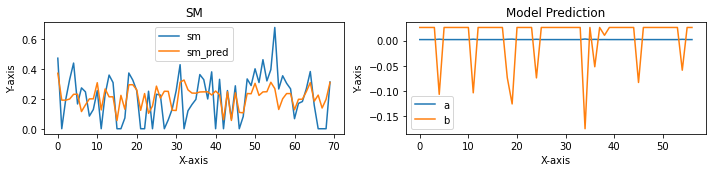

Epoch [97/5000] (LR: 0.00025):
Train loss: 0.0185 || Train physical loss: 0.0185
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0185 || Valid physical loss: 0.0185
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


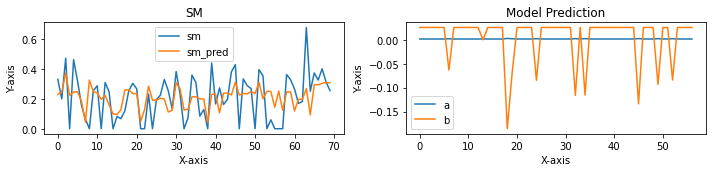

Epoch [98/5000] (LR: 0.00025):
Train loss: 0.0190 || Train physical loss: 0.0190
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0185 || Valid physical loss: 0.0185
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


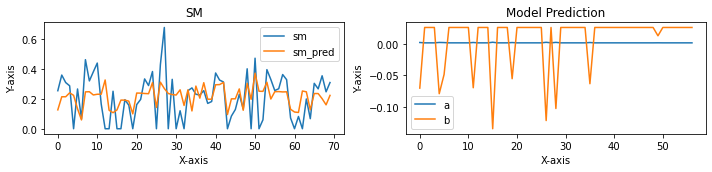

Epoch [99/5000] (LR: 0.00025):
Train loss: 0.1436 || Train physical loss: 0.0180
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1256
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


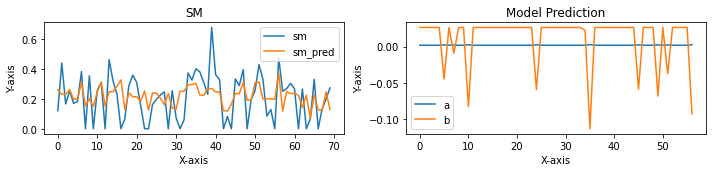

Epoch [100/5000] (LR: 0.00025):
Train loss: 0.0186 || Train physical loss: 0.0186
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0190 || Valid physical loss: 0.0190
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


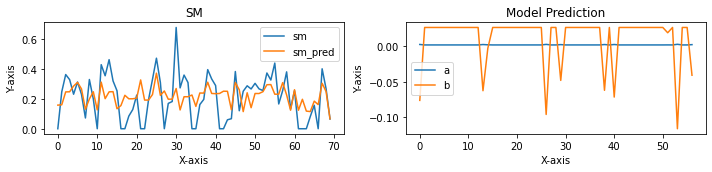

Epoch [101/5000] (LR: 0.00025):
Train loss: 0.0193 || Train physical loss: 0.0193
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0191 || Valid physical loss: 0.0191
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


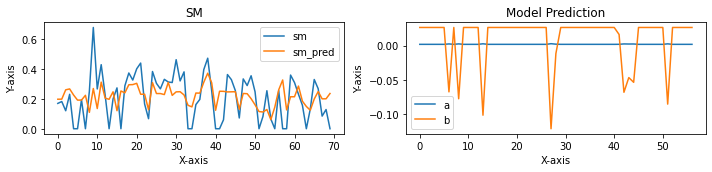

Epoch [102/5000] (LR: 0.000125):
Train loss: 0.0188 || Train physical loss: 0.0188
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0191 || Valid physical loss: 0.0191
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


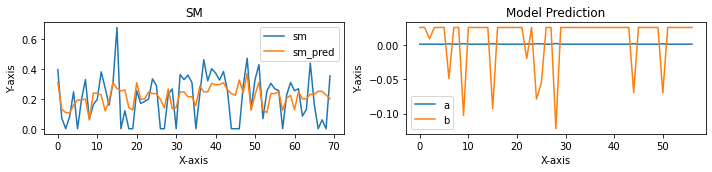

Epoch [103/5000] (LR: 0.000125):
Train loss: 0.0193 || Train physical loss: 0.0193
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0190 || Valid physical loss: 0.0190
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


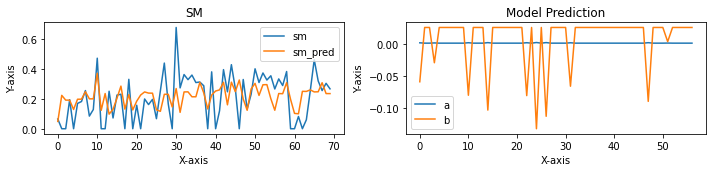

Epoch [104/5000] (LR: 0.000125):
Train loss: 0.0194 || Train physical loss: 0.0194
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0190 || Valid physical loss: 0.0190
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


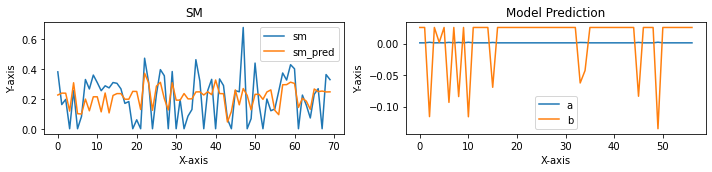

Epoch [105/5000] (LR: 0.000125):
Train loss: 0.0193 || Train physical loss: 0.0193
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0189 || Valid physical loss: 0.0189
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


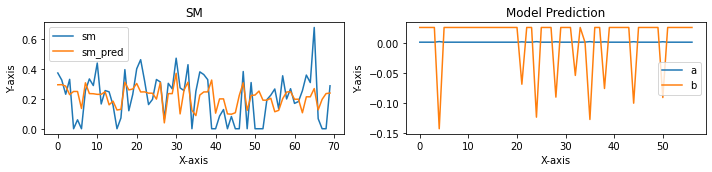

Epoch [106/5000] (LR: 0.000125):
Train loss: 0.0186 || Train physical loss: 0.0186
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0189 || Valid physical loss: 0.0189
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


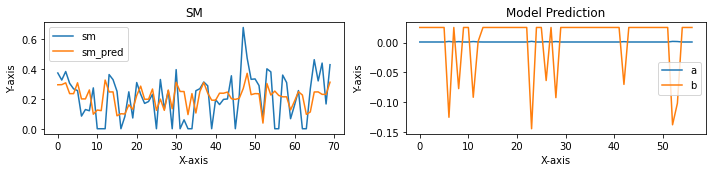

Epoch [107/5000] (LR: 0.000125):
Train loss: 0.0181 || Train physical loss: 0.0181
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0189 || Valid physical loss: 0.0189
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


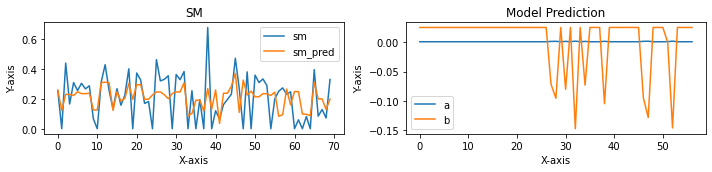

Epoch [108/5000] (LR: 0.000125):
Train loss: 0.0185 || Train physical loss: 0.0185
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0188 || Valid physical loss: 0.0188
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


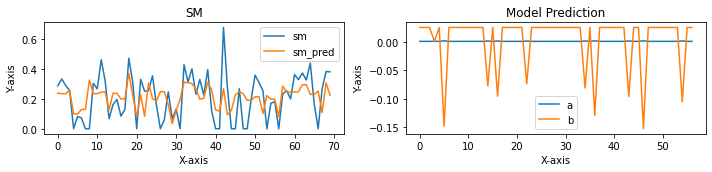

Epoch [109/5000] (LR: 0.000125):
Train loss: 0.0184 || Train physical loss: 0.0184
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0188 || Valid physical loss: 0.0188
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


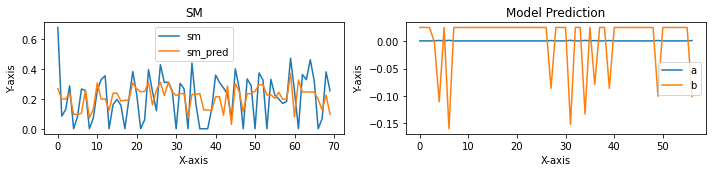

Epoch [110/5000] (LR: 0.000125):
Train loss: 0.0191 || Train physical loss: 0.0191
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0188 || Valid physical loss: 0.0188
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


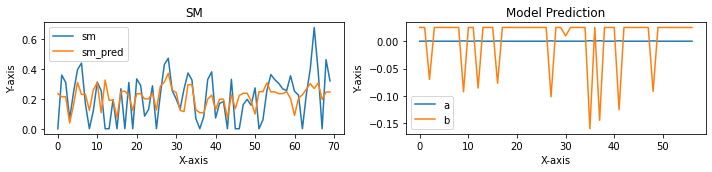

Epoch [111/5000] (LR: 0.000125):
Train loss: 0.1442 || Train physical loss: 0.0176
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1266
Valid loss: 0.0187 || Valid physical loss: 0.0187
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


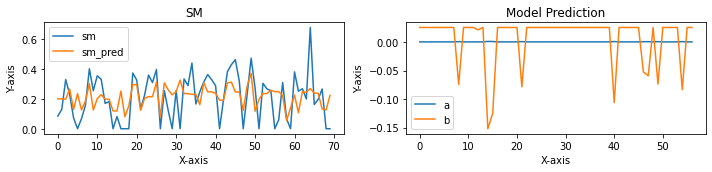

Epoch [112/5000] (LR: 0.000125):
Train loss: 0.2686 || Train physical loss: 0.0186
Train sd_nonzero_loss: 0.2500 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0185 || Valid physical loss: 0.0185
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


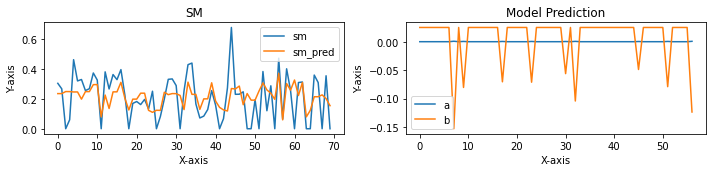

Epoch [113/5000] (LR: 6.25e-05):
Train loss: 0.0182 || Train physical loss: 0.0182
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0185 || Valid physical loss: 0.0185
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


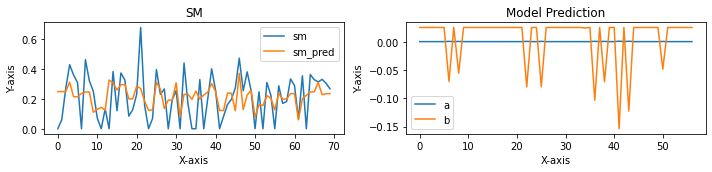

Epoch [114/5000] (LR: 6.25e-05):
Train loss: 0.0183 || Train physical loss: 0.0183
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0185 || Valid physical loss: 0.0185
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


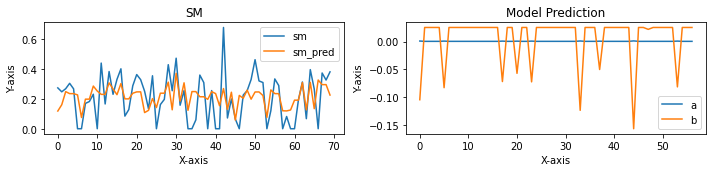

Epoch [115/5000] (LR: 6.25e-05):
Train loss: 0.0181 || Train physical loss: 0.0181
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0185 || Valid physical loss: 0.0185
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


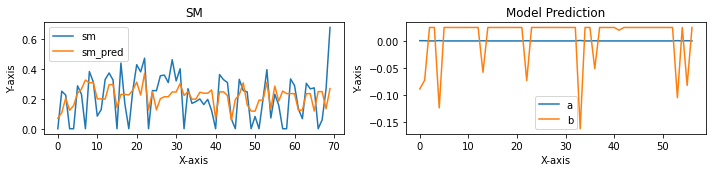

Epoch [116/5000] (LR: 6.25e-05):
Train loss: 0.0182 || Train physical loss: 0.0182
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0185 || Valid physical loss: 0.0185
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


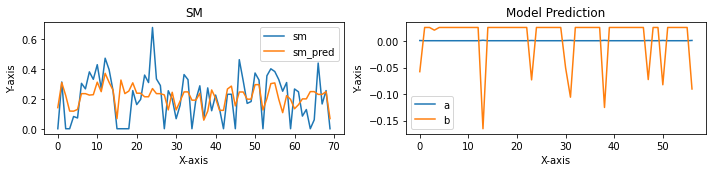

Epoch [117/5000] (LR: 6.25e-05):
Train loss: 0.0179 || Train physical loss: 0.0179
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0185 || Valid physical loss: 0.0185
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


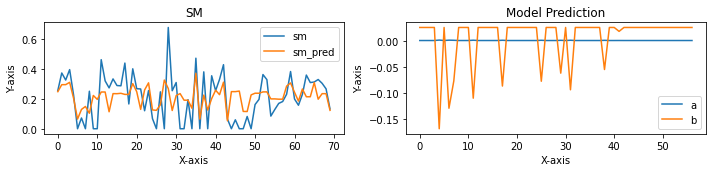

Epoch [118/5000] (LR: 6.25e-05):
Train loss: 0.0189 || Train physical loss: 0.0189
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0185 || Valid physical loss: 0.0185
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


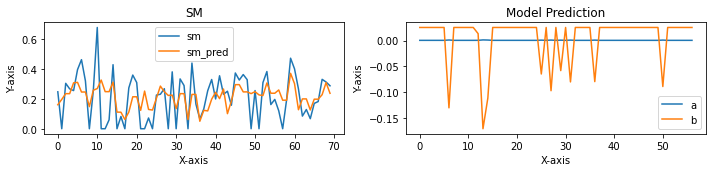

Epoch [119/5000] (LR: 6.25e-05):
Train loss: 0.0182 || Train physical loss: 0.0182
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0185 || Valid physical loss: 0.0185
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


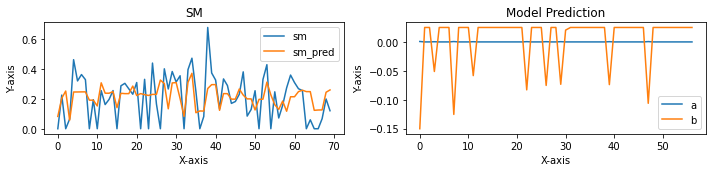

Epoch [120/5000] (LR: 6.25e-05):
Train loss: 0.1432 || Train physical loss: 0.0182
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1250
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


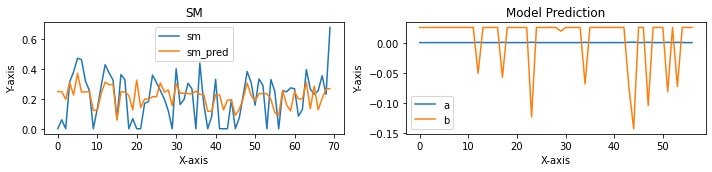

Epoch [121/5000] (LR: 6.25e-05):
Train loss: 0.0181 || Train physical loss: 0.0181
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


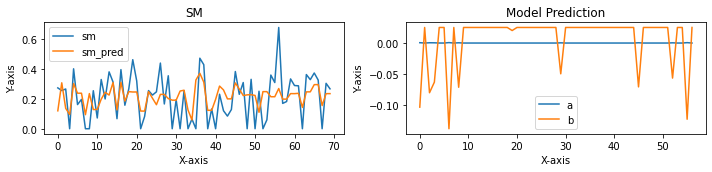

Epoch [122/5000] (LR: 6.25e-05):
Train loss: 0.0187 || Train physical loss: 0.0187
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


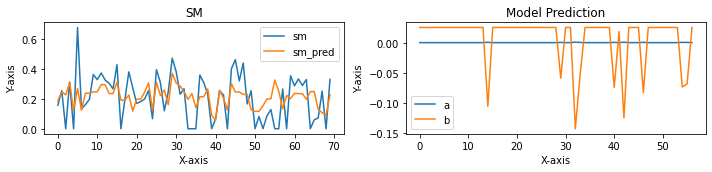

Epoch [123/5000] (LR: 6.25e-05):
Train loss: 0.0188 || Train physical loss: 0.0188
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


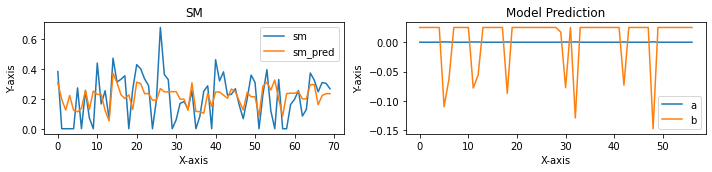

Epoch [124/5000] (LR: 3.125e-05):
Train loss: 0.0182 || Train physical loss: 0.0182
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


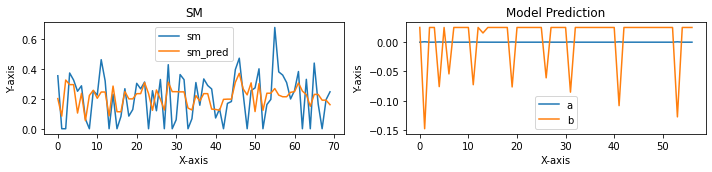

Epoch [125/5000] (LR: 3.125e-05):
Train loss: 0.0187 || Train physical loss: 0.0187
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


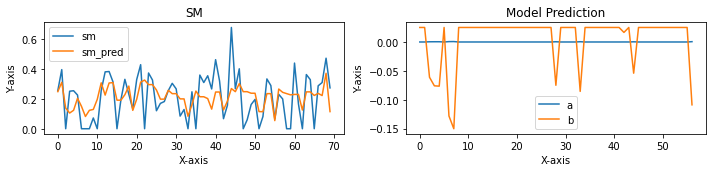

Epoch [126/5000] (LR: 3.125e-05):
Train loss: 0.0188 || Train physical loss: 0.0188
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


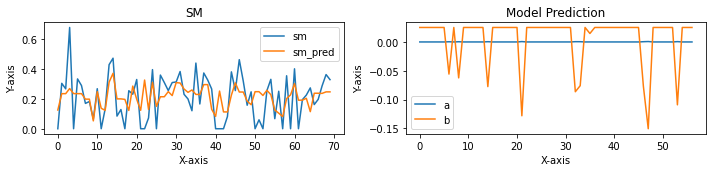

Epoch [127/5000] (LR: 3.125e-05):
Train loss: 0.0182 || Train physical loss: 0.0182
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


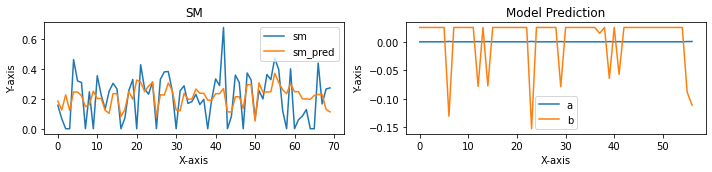

Epoch [128/5000] (LR: 3.125e-05):
Train loss: 0.0183 || Train physical loss: 0.0183
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


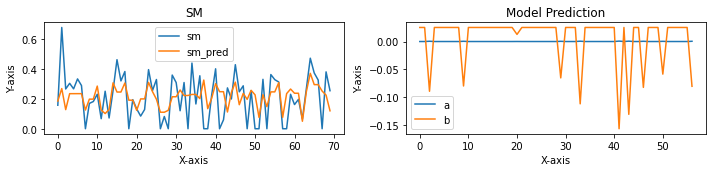

Epoch [129/5000] (LR: 3.125e-05):
Train loss: 0.0182 || Train physical loss: 0.0182
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


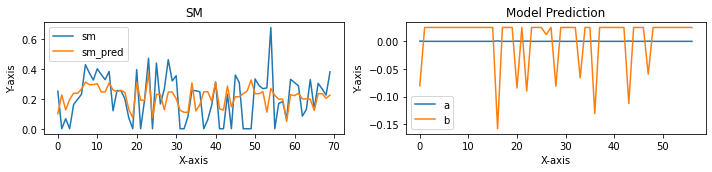

Epoch [130/5000] (LR: 3.125e-05):
Train loss: 0.0186 || Train physical loss: 0.0186
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0185 || Valid physical loss: 0.0185
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


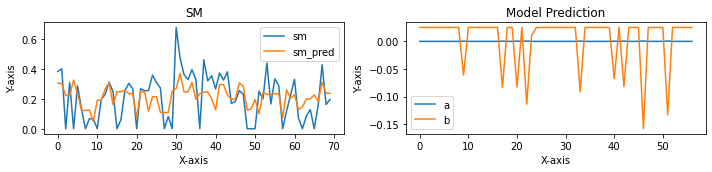

Epoch [131/5000] (LR: 3.125e-05):
Train loss: 0.0180 || Train physical loss: 0.0180
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


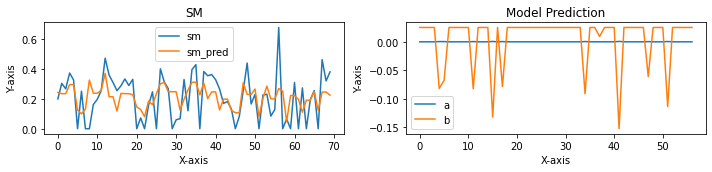

Epoch [132/5000] (LR: 3.125e-05):
Train loss: 0.1437 || Train physical loss: 0.0187
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1250
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


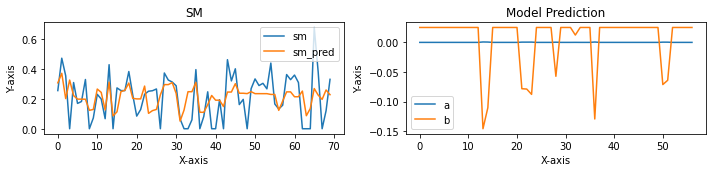

Epoch [133/5000] (LR: 3.125e-05):
Train loss: 0.0184 || Train physical loss: 0.0184
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


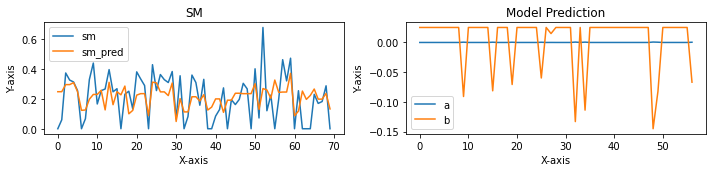

Epoch [134/5000] (LR: 3.125e-05):
Train loss: 0.0187 || Train physical loss: 0.0187
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 1.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 1.0000 || Valid sm_nonzero_loss: 0.0000


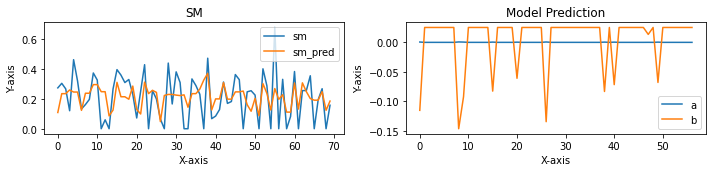

Epoch [135/5000] (LR: 1.5625e-05):
Train loss: 0.1431 || Train physical loss: 0.0181
Train sd_nonzero_loss: 0.1250 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


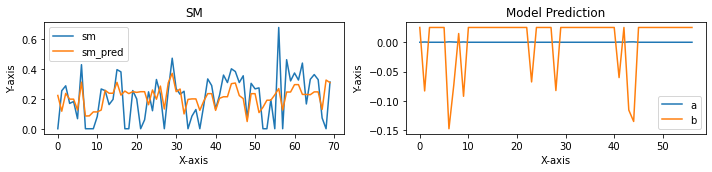

Epoch [136/5000] (LR: 1.5625e-05):
Train loss: 0.0184 || Train physical loss: 0.0184
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


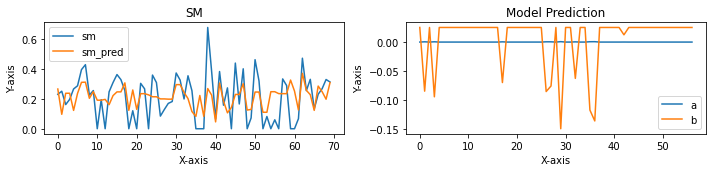

Epoch [137/5000] (LR: 1.5625e-05):
Train loss: 0.0182 || Train physical loss: 0.0182
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


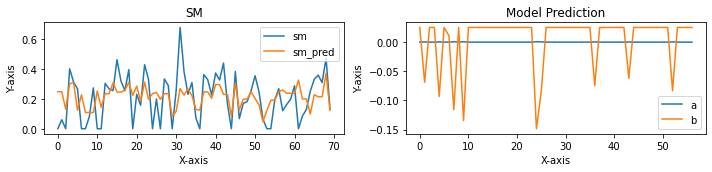

Epoch [138/5000] (LR: 1.5625e-05):
Train loss: 0.0186 || Train physical loss: 0.0186
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


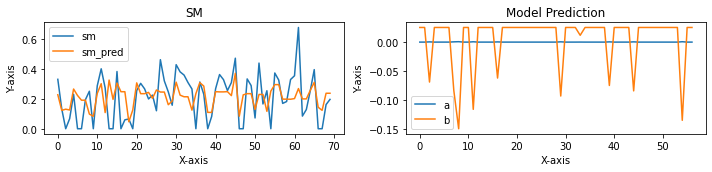

Epoch [139/5000] (LR: 1.5625e-05):
Train loss: 0.0187 || Train physical loss: 0.0187
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


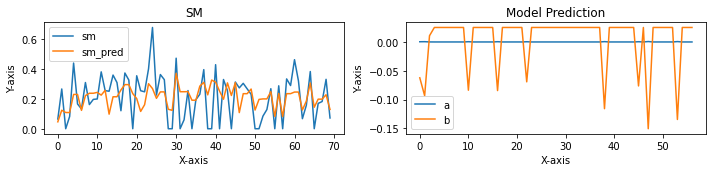

Epoch [140/5000] (LR: 1.5625e-05):
Train loss: 0.0180 || Train physical loss: 0.0180
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


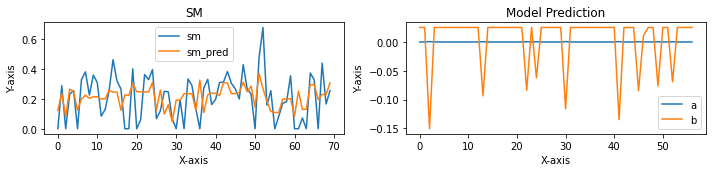

Epoch [141/5000] (LR: 1.5625e-05):
Train loss: 0.0184 || Train physical loss: 0.0184
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


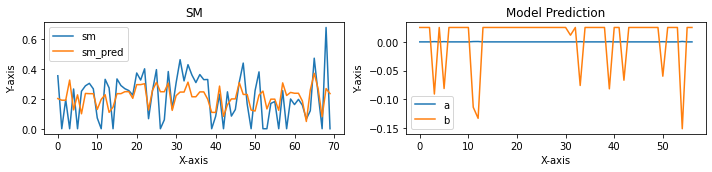

Epoch [142/5000] (LR: 1.5625e-05):
Train loss: 0.0178 || Train physical loss: 0.0178
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


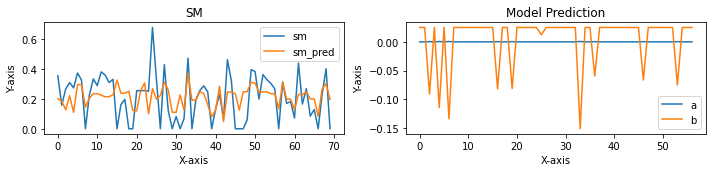

Epoch [143/5000] (LR: 1.5625e-05):
Train loss: 0.1435 || Train physical loss: 0.0185
Train sd_nonzero_loss: 0.1250 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


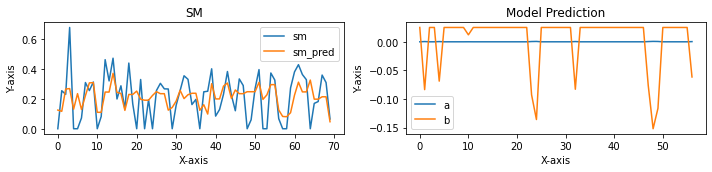

Epoch [144/5000] (LR: 1.5625e-05):
Train loss: 0.0182 || Train physical loss: 0.0182
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


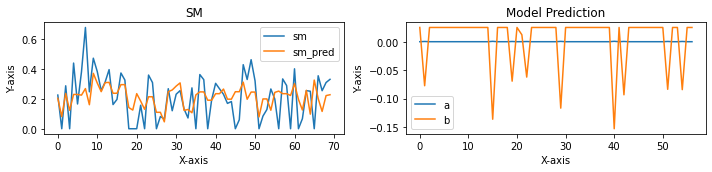

Epoch [145/5000] (LR: 1.5625e-05):
Train loss: 0.0180 || Train physical loss: 0.0180
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


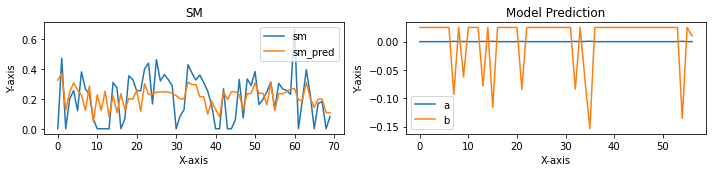

Epoch [146/5000] (LR: 7.8125e-06):
Train loss: 0.0185 || Train physical loss: 0.0185
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


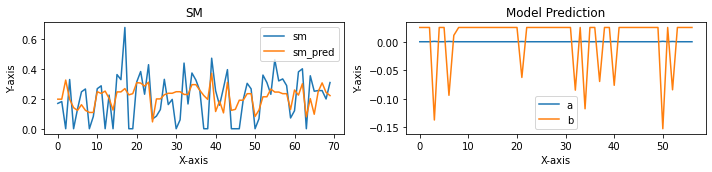

Epoch [147/5000] (LR: 7.8125e-06):
Train loss: 0.0179 || Train physical loss: 0.0179
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


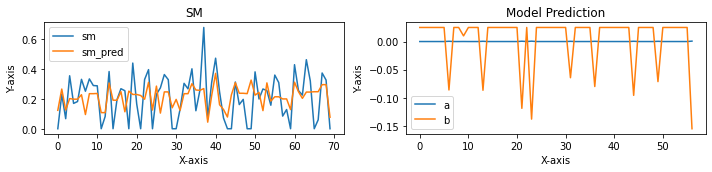

Epoch [148/5000] (LR: 7.8125e-06):
Train loss: 0.0189 || Train physical loss: 0.0189
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


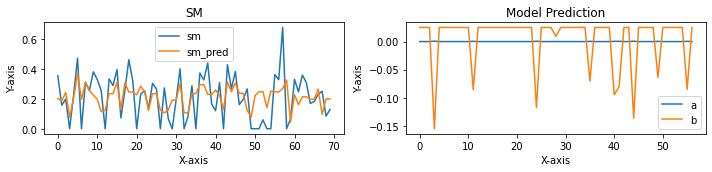

Epoch [149/5000] (LR: 7.8125e-06):
Train loss: 0.1435 || Train physical loss: 0.0184
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1251
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


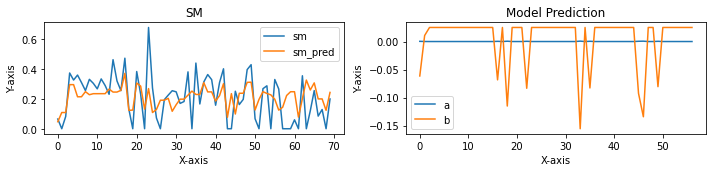

Epoch [150/5000] (LR: 7.8125e-06):
Train loss: 0.2691 || Train physical loss: 0.0191
Train sd_nonzero_loss: 0.2500 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


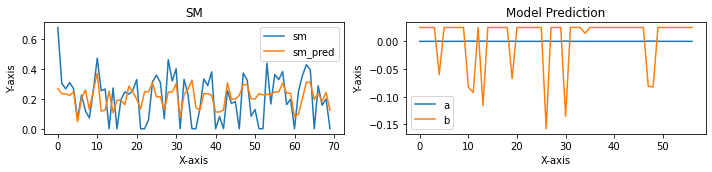

Epoch [151/5000] (LR: 7.8125e-06):
Train loss: 0.0186 || Train physical loss: 0.0186
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


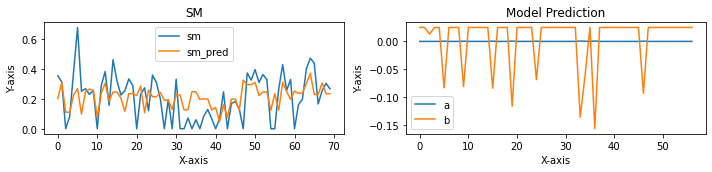

Epoch [152/5000] (LR: 7.8125e-06):
Train loss: 0.0181 || Train physical loss: 0.0181
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


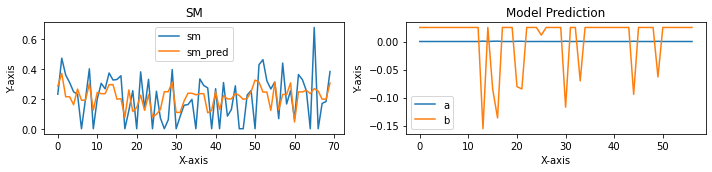

Epoch [153/5000] (LR: 7.8125e-06):
Train loss: 0.0185 || Train physical loss: 0.0185
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


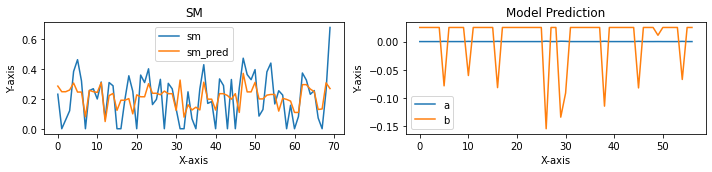

Epoch [154/5000] (LR: 7.8125e-06):
Train loss: 0.0183 || Train physical loss: 0.0183
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


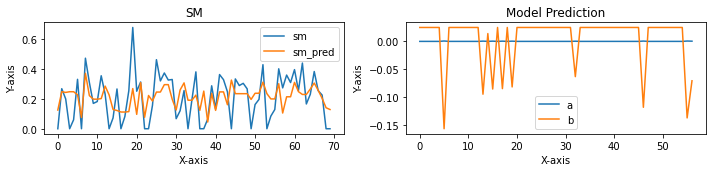

Epoch [155/5000] (LR: 7.8125e-06):
Train loss: 0.0182 || Train physical loss: 0.0182
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


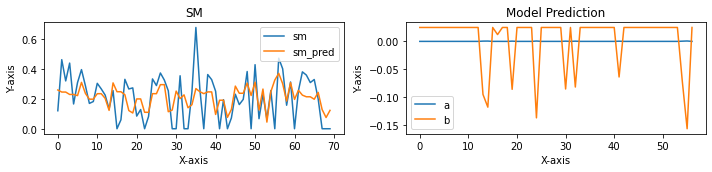

Epoch [156/5000] (LR: 7.8125e-06):
Train loss: 0.0185 || Train physical loss: 0.0185
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


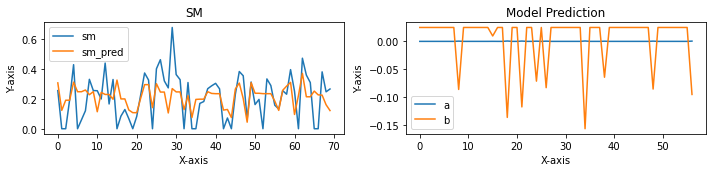

Epoch [157/5000] (LR: 3.90625e-06):
Train loss: 0.0181 || Train physical loss: 0.0181
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


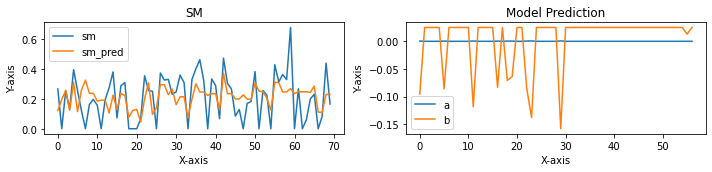

Epoch [158/5000] (LR: 3.90625e-06):
Train loss: 0.0181 || Train physical loss: 0.0181
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


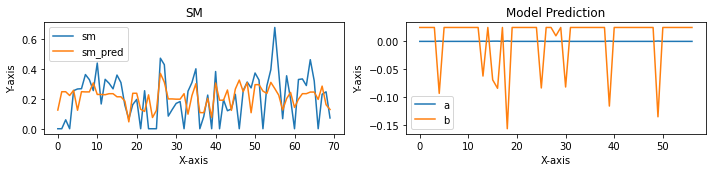

Epoch [159/5000] (LR: 3.90625e-06):
Train loss: 0.0184 || Train physical loss: 0.0184
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


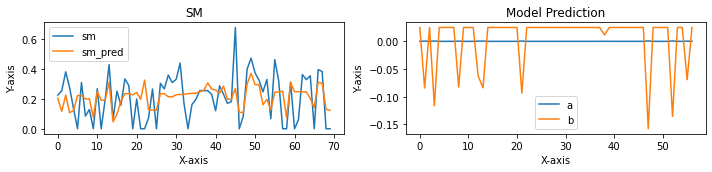

Epoch [160/5000] (LR: 3.90625e-06):
Train loss: 0.0181 || Train physical loss: 0.0181
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


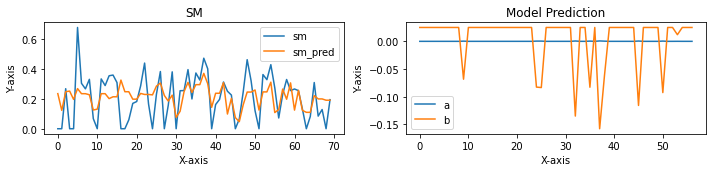

Epoch [161/5000] (LR: 3.90625e-06):
Train loss: 0.0191 || Train physical loss: 0.0191
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


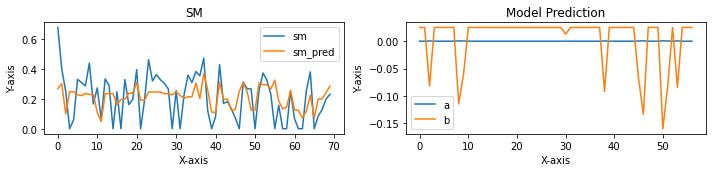

Epoch [162/5000] (LR: 3.90625e-06):
Train loss: 0.0181 || Train physical loss: 0.0181
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


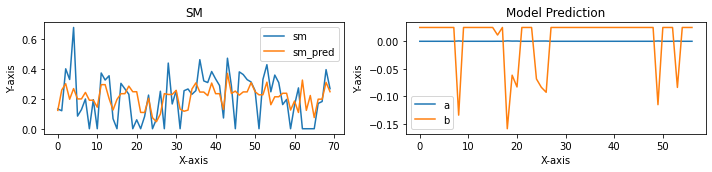

Epoch [163/5000] (LR: 3.90625e-06):
Train loss: 0.0188 || Train physical loss: 0.0188
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


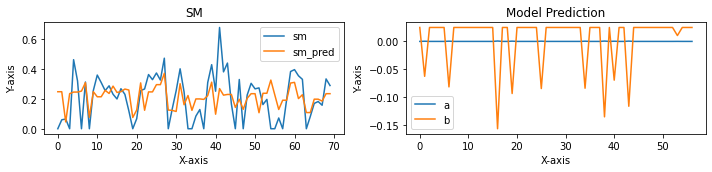

Epoch [164/5000] (LR: 3.90625e-06):
Train loss: 0.0181 || Train physical loss: 0.0181
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


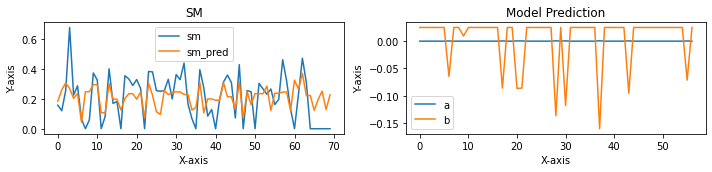

Epoch [165/5000] (LR: 3.90625e-06):
Train loss: 0.0186 || Train physical loss: 0.0186
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


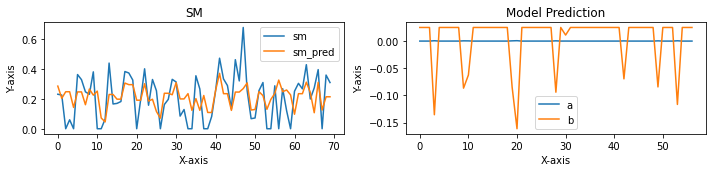

Epoch [166/5000] (LR: 3.90625e-06):
Train loss: 0.0183 || Train physical loss: 0.0183
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


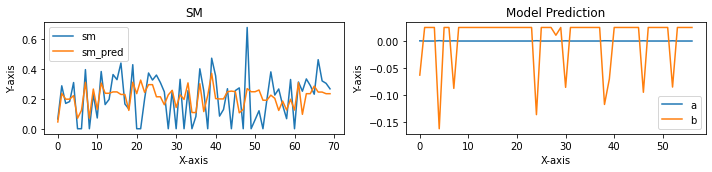

Epoch [167/5000] (LR: 3.90625e-06):
Train loss: 0.0183 || Train physical loss: 0.0183
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


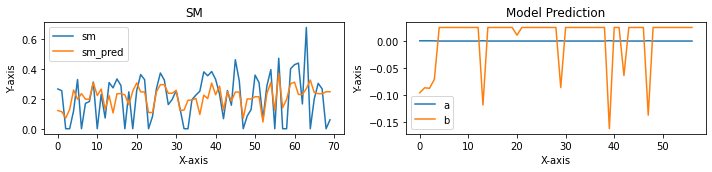

Epoch [168/5000] (LR: 1.953125e-06):
Train loss: 0.0185 || Train physical loss: 0.0185
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


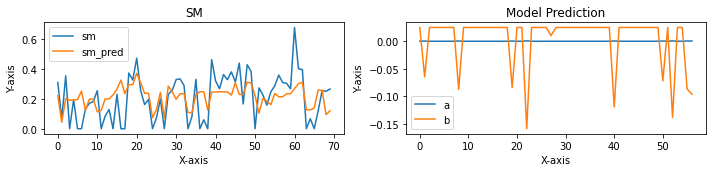

Epoch [169/5000] (LR: 1.953125e-06):
Train loss: 0.0180 || Train physical loss: 0.0180
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


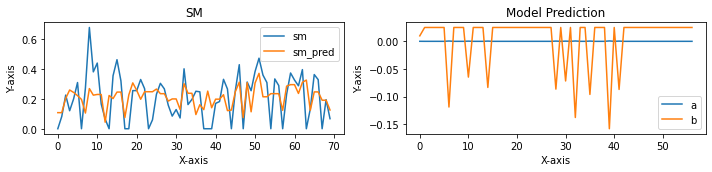

Epoch [170/5000] (LR: 1.953125e-06):
Train loss: 0.1437 || Train physical loss: 0.0184
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1254
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


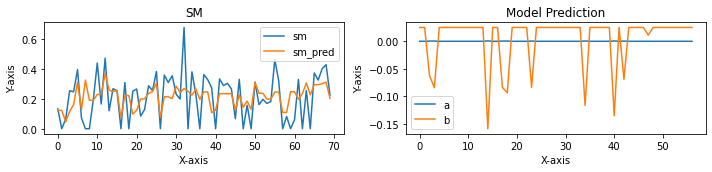

Epoch [171/5000] (LR: 1.953125e-06):
Train loss: 0.0181 || Train physical loss: 0.0181
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


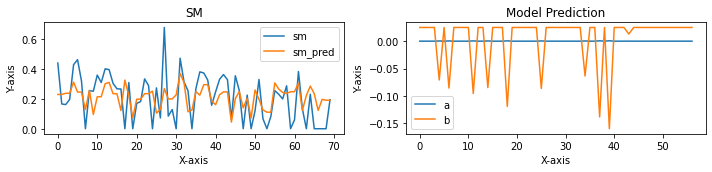

Epoch [172/5000] (LR: 1.953125e-06):
Train loss: 0.0184 || Train physical loss: 0.0184
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


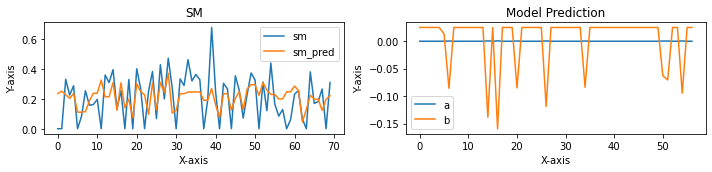

Epoch [173/5000] (LR: 1.953125e-06):
Train loss: 0.0187 || Train physical loss: 0.0187
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


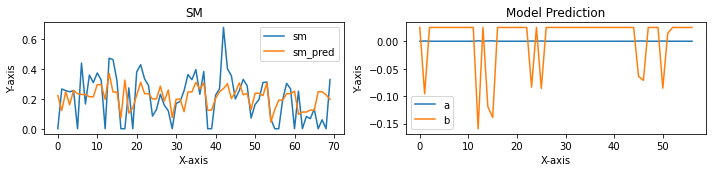

Epoch [174/5000] (LR: 1.953125e-06):
Train loss: 0.0182 || Train physical loss: 0.0182
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


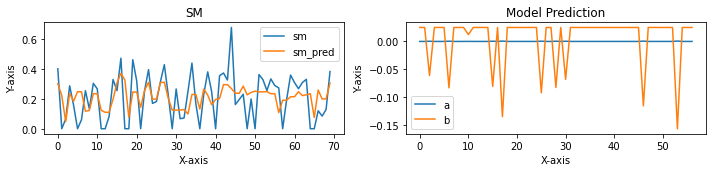

Epoch [175/5000] (LR: 1.953125e-06):
Train loss: 0.0187 || Train physical loss: 0.0187
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


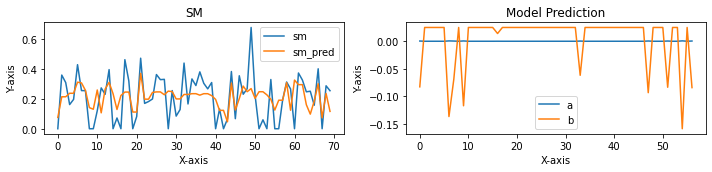

Epoch [176/5000] (LR: 1.953125e-06):
Train loss: 0.0184 || Train physical loss: 0.0184
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


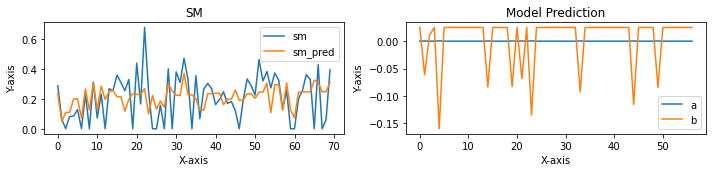

Epoch [177/5000] (LR: 1.953125e-06):
Train loss: 0.1435 || Train physical loss: 0.0185
Train sd_nonzero_loss: 0.1250 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


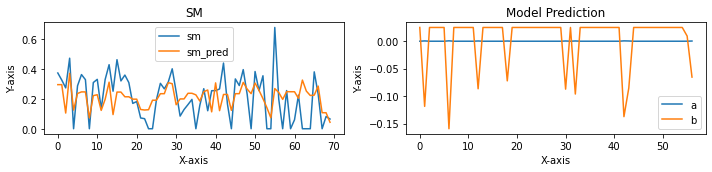

Epoch [178/5000] (LR: 1.953125e-06):
Train loss: 0.0184 || Train physical loss: 0.0184
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


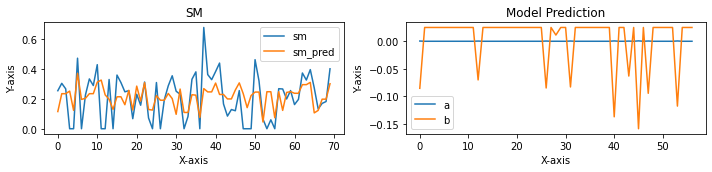

Epoch [179/5000] (LR: 9.765625e-07):
Train loss: 0.0193 || Train physical loss: 0.0193
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


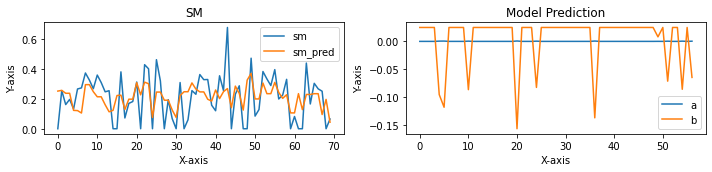

Epoch [180/5000] (LR: 9.765625e-07):
Train loss: 0.0181 || Train physical loss: 0.0181
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


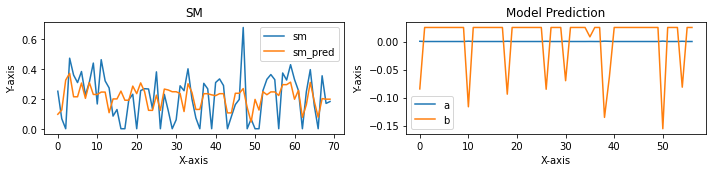

Epoch [181/5000] (LR: 9.765625e-07):
Train loss: 0.1436 || Train physical loss: 0.0185
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.1251
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


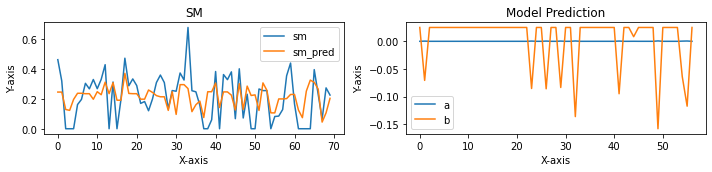

Epoch [182/5000] (LR: 9.765625e-07):
Train loss: 0.0188 || Train physical loss: 0.0188
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


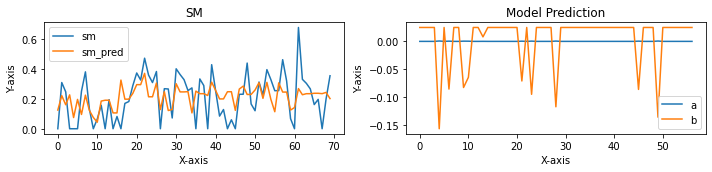

Epoch [183/5000] (LR: 9.765625e-07):
Train loss: 0.0180 || Train physical loss: 0.0180
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


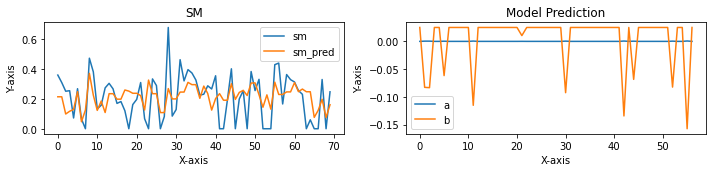

Epoch [184/5000] (LR: 9.765625e-07):
Train loss: 0.0183 || Train physical loss: 0.0183
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


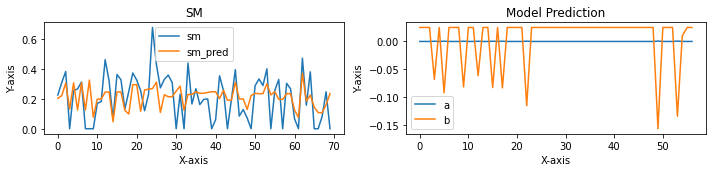

Epoch [185/5000] (LR: 9.765625e-07):
Train loss: 0.0180 || Train physical loss: 0.0180
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


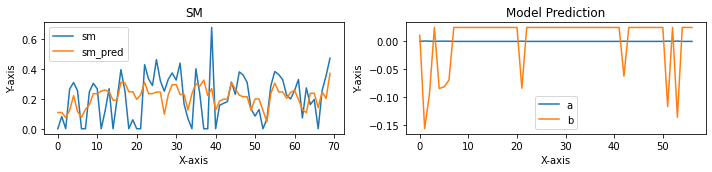

Epoch [186/5000] (LR: 9.765625e-07):
Train loss: 0.0184 || Train physical loss: 0.0184
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


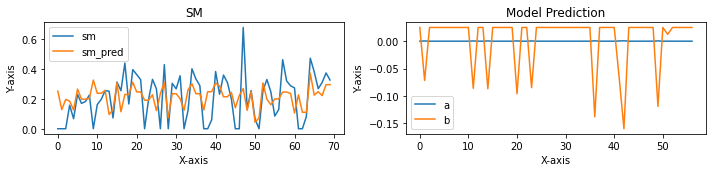

Epoch [187/5000] (LR: 9.765625e-07):
Train loss: 0.0184 || Train physical loss: 0.0184
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


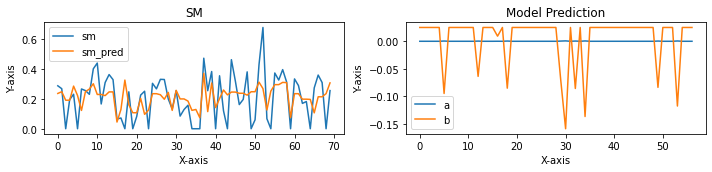

Epoch [188/5000] (LR: 9.765625e-07):
Train loss: 0.0190 || Train physical loss: 0.0190
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


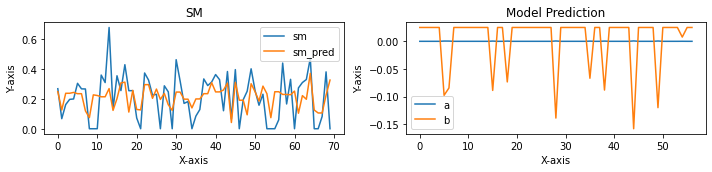

Epoch [189/5000] (LR: 9.765625e-07):
Train loss: 0.0185 || Train physical loss: 0.0185
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000


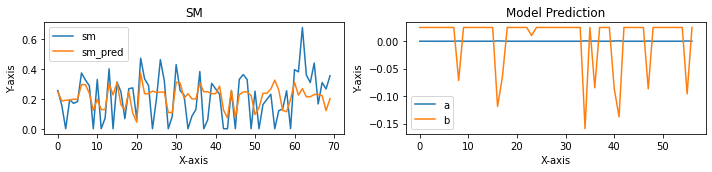

Epoch [190/5000] (LR: 4.8828125e-07):
Train loss: 0.0180 || Train physical loss: 0.0180
Train sd_nonzero_loss: 0.0000 || Train sm_nonzero_loss: 0.0000
Valid loss: 0.0186 || Valid physical loss: 0.0186
Valid sd_nonzero_loss: 0.0000 || Valid sm_nonzero_loss: 0.0000

Model is not improving, so we halt the training session.


In [8]:
# 创建模型保存目录
if os.path.exists(config['model_save_dir'])==False:
    os.makedirs(config['model_save_dir'], exist_ok=True)
    
if config['is_train']==True:
    print(dataset.get_input_shape(0))
    model = SMCNN(input_channel=dataset.get_input_shape(0)[2]).to(device) # put your model and data on the same computation device.
    print(model)
    trainer(train_loader, valid_loader, model, config, device)

## Testing

In [9]:
def tester(test_loader, model, config, device):
    relu = torch.nn.ReLU(inplace=True)
    criterion = self_defined_sm_loss
    model.eval() 
    loss_record = []
    physical_loss_record = []
    sd_nonzero_loss_record = []
    sm_nonzero_loss_record = []
    for data_pkg in test_loader:
        x = data_pkg['processed_data']
        with torch.no_grad():
            pred = model(x)
#             x, pred = x.to(device), pred.to(device)  
            physical_loss, sd_nonzero_loss, sm_nonzero_loss = criterion(pred, data_pkg['label_data'], 'Validing', config['sim_threshold'])
            loss = physical_loss + sd_nonzero_loss + sm_nonzero_loss

            physical_loss_record.append(physical_loss.item())
            sd_nonzero_loss_record.append(sd_nonzero_loss.item())
            sm_nonzero_loss_record.append(sm_nonzero_loss.item())
            loss_record.append(loss.item())

    mean_test_physical_loss = sum(physical_loss_record)/len(physical_loss_record)
    mean_test_sd_nonzero_loss = sum(sd_nonzero_loss_record)/len(sd_nonzero_loss_record)
    mean_test_sm_nonzero_loss = sum(sm_nonzero_loss_record)/len(sm_nonzero_loss_record)
    mean_test_loss = sum(loss_record)/len(loss_record)

    print(f'Test loss: {mean_test_loss:.4f} || Test physical loss: {mean_test_physical_loss:.4f}')
    print(f'Test sd_nonzero_loss: {mean_test_sd_nonzero_loss:.4f} || Test sm_nonzero_loss: {mean_test_sm_nonzero_loss:.4f}')
        
    return physical_loss_record

(11, 11, 20)
SMCNN(
  (cnn): Sequential(
    (0): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3872, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=2, bias=True)
  )
)


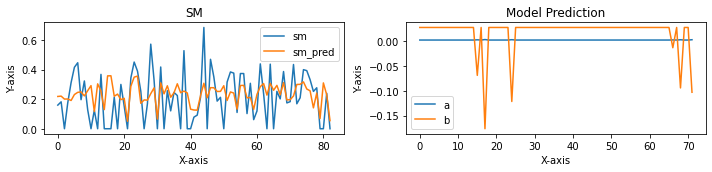

Test loss: 0.0243 || Test physical loss: 0.0243
Test sd_nonzero_loss: 0.0000 || Test sm_nonzero_loss: 0.0000


In [10]:
param_path = os.path.join(config['model_save_dir'],'first.ckpt' )
print(dataset.get_input_shape(0))
model = SMCNN(input_channel=dataset.get_input_shape(0)[2]).to(device)
print(model)
model.load_state_dict(torch.load(param_path))
loss_record = tester(test_loader, model, config, device) 